In [2]:
from F00_global_variables import *
os.chdir('/mnt/08_thymus_cell_atlas/')

sys.path.append('/mnt/thymus_atlas')
import scjp
from scjp import markers, model, draw, utils

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, color_map='OrRd')
sc.logging.print_version_and_date()
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

version = 'HTA08.v01.A07.'

print('Version: '+version)

Running Scanpy 1.4.3 on 2019-09-27 15:41.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Version: HTA08.v01.A07.


## Load thymus data

In [73]:
ndata = sc.read('HTA08.v01.A05.fig1_data_vdj_added')

Only considering the two last: ['.A05', '.fig1_data_vdj_added'].


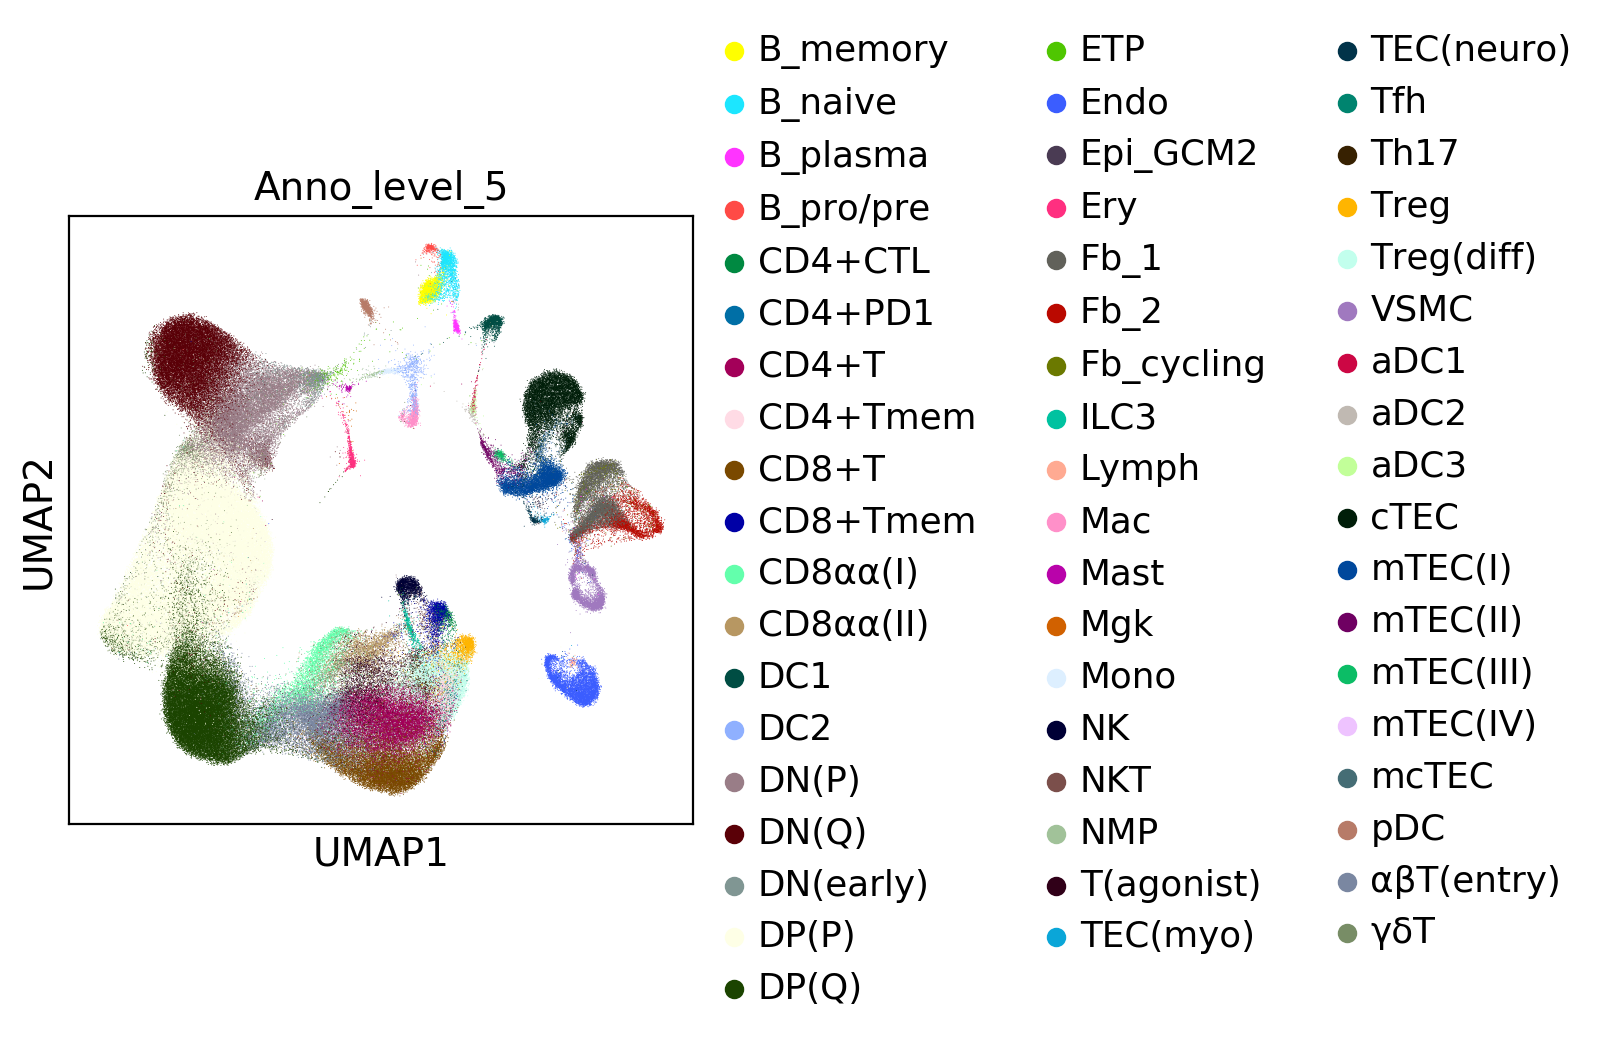

In [4]:
scjp.us(ndata,'Anno_level_5')

## Load Staal et al (processed data)

In [5]:
df = pd.read_csv('05_Staal/E-MEXP-337-processed-data-1342692420.txt',sep='\t')

In [6]:
df.head()

Hybridization REF  \
0                              Composite Element REF   
1  Affymetrix:CompositeSequence:HG-U133A:AFFX-Bio...   
2  Affymetrix:CompositeSequence:HG-U133A:AFFX-Bio...   
3  Affymetrix:CompositeSequence:HG-U133A:AFFX-Bio...   
4  Affymetrix:CompositeSequence:HG-U133A:AFFX-Bio...   

                             UCB CD34+ B;UCB CD34+ A  \
0  Software Unknown:Average Expression Level: Scaled   
1                                               26.4   
2                                              30.46   
3                                              36.31   
4                                              51.12   

                       CD34+38- B;CD34+38- A  \
0  Software Unknown:Average Expression Level   
1                                      36.69   
2                                       37.8   
3                                      43.89   
4                                      71.99   

                       CD34+1a- A;CD34+1a- C  \
0  Software Unknown:Average Expression Level   
1                                      24.32   
2                                      29.15   
3                                       30.8   
4                                      43.01   

                   UCB CD34+ B;UCB CD34+ A.1  \
0  Software Unknown:Average Expression Level   
1                                       26.4   
2                                      30.46   
3                                      36.31   
4                                      51.12   

                     CD34+38- B;CD34+38- A.1  \
0  Software Unknown:Average Expression Level   
1                                      24.44   
2                                       30.4   
3                                      31.35   
4                                      44.27   

  CD34+1a- A;CD34+1a- C;CD34+1a- B;CD34+1a- D  \
0   Software Unknown:Average Expression Level   
1                                       24.32   
2                                       29.15   
3                                        30.8   
4                                       43.01   

                       CD34+1a+ A;CD34+1a+ B  \
0  Software Unknown:Average Expression Level   
1                                      23.26   
2                                      26.41   
3                                      30.33   
4                                      45.44   

                       ISP CD4+ A;ISP CD4+ B  \
0  Software Unknown:Average Expression Level   
1                                      20.67   
2                                      21.55   
3                                      23.72   
4                                      38.58   

                           DPCD3- A;DPCD3- B  \
0  Software Unknown:Average Expression Level   
1                                      22.32   
2                                      21.98   
3                                      23.58   
4                                      40.99   

                         DP CD3+ A;DP CD3+ B  \
0  Software Unknown:Average Expression Level   
1                                      23.18   
2                                      25.17   
3                                      28.31   
4                                      45.09   

                         SP CD4+ B;SP CD4+ A  \
0  Software Unknown:Average Expression Level   
1                                      22.54   
2                                      21.78   
3                                      23.74   
4                                      40.09   

                         SP CD8+ B;SP CD8+ A  
0  Software Unknown:Average Expression Level  
1                                      21.25  
2                                      21.97  
3                                      23.21  
4                                      37.59

In [7]:
df['PROBEID'] = [x.split(":")[-1] for x in df['Hybridization REF']]

In [8]:
cvt_table = pd.read_csv('05_Staal/ID_convert.tsv',sep='\t')

In [9]:
df_symbol = pd.merge(df, cvt_table, left_on = 'PROBEID', right_on = 'PROBEID', how = 'left')

In [10]:
df_symbol = df_symbol[~(df_symbol['SYMBOL'].isna())]

In [11]:
mean_list = []
sym_list = []

for sym, sdf in df_symbol.groupby('SYMBOL'):
    sym_list.append(sym)
    mean_list.append(np.array(sdf.iloc[:,1:13],dtype=float).mean(axis=0))


In [12]:
df_staal = pd.DataFrame(np.vstack(mean_list))
df_staal.index = sym_list
df_staal.columns = sdf.columns[1:13]

In [13]:
sdata = sc.AnnData(df_staal.T)
sdata.var_names = df_staal.index
sdata.obs_names = df_staal.columns

In [14]:
sc.pp.normalize_per_cell(sdata,counts_per_cell_after=10e4)
sc.pp.log1p(sdata)
sdata.raw = sdata

In [15]:
sc.pp.scale(sdata,max_value=10)

In [16]:
ndata_T = ndata[ndata.obs['Anno_level_3'].isin('ETP,DN,DP,T_naive'.split(','))].copy()

In [17]:
mks_T_Staal = scjp.markers.find_markers(ndata_T,'Anno_level_Staal',min_drop_cut=0.3,min_mean_cut=0,thres=0.2,single=True)

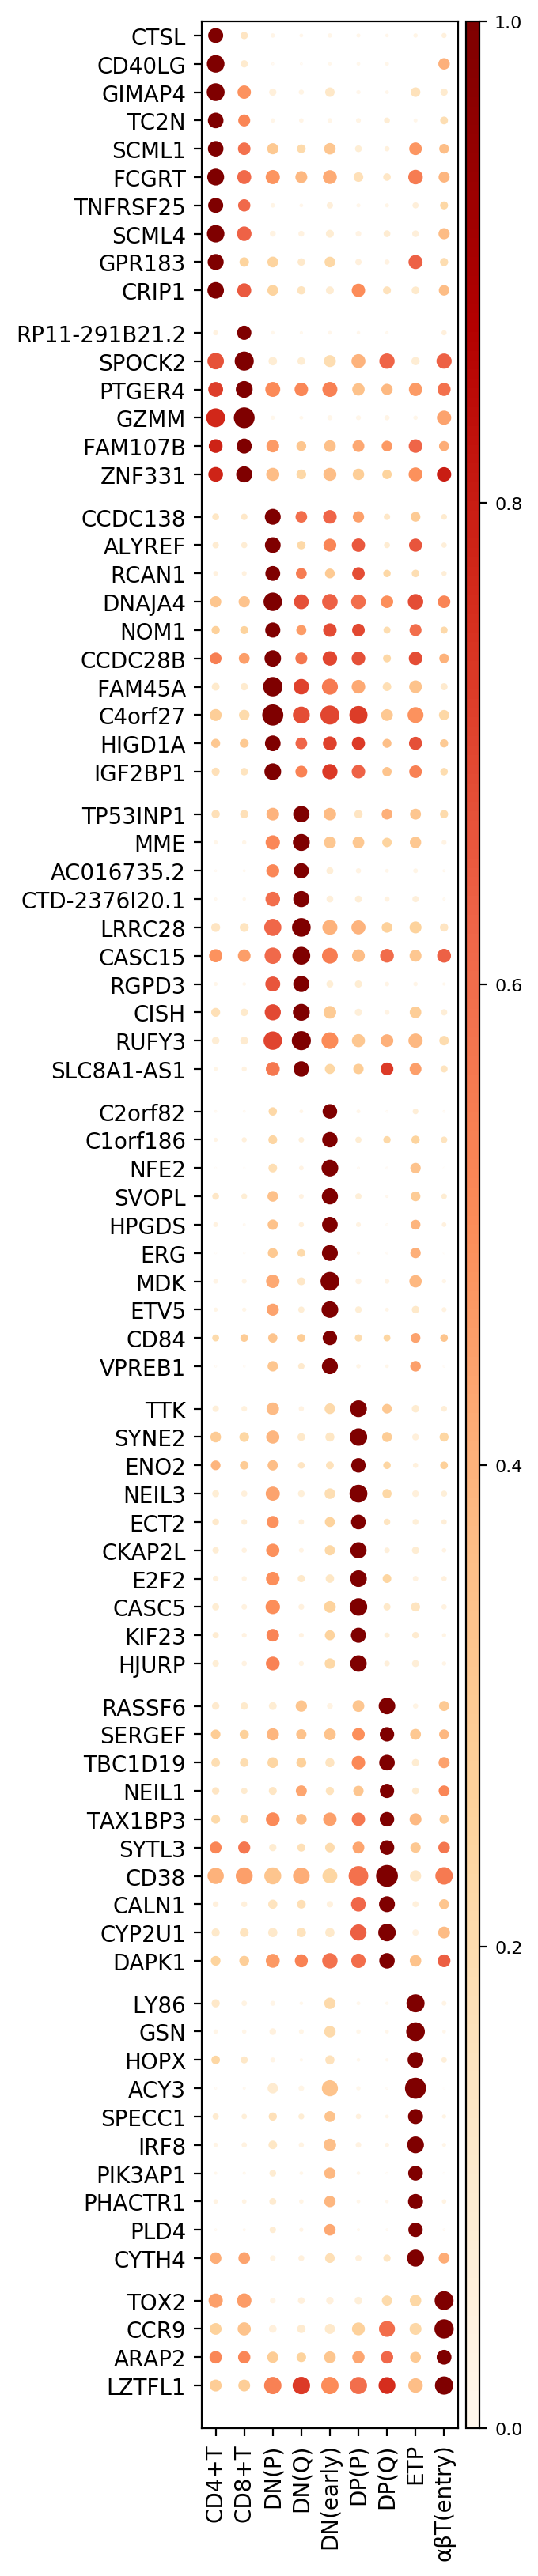

In [20]:
mk_genes_Staal = scjp.markers.show_marker_plot(ndata_T,'Anno_level_Staal',mks_T_Staal)

In [21]:
mks_T_4 = scjp.markers.find_markers(ndata_T,'Anno_level_4',min_drop_cut=0.3,min_mean_cut=0,thres=0.2,single=True)

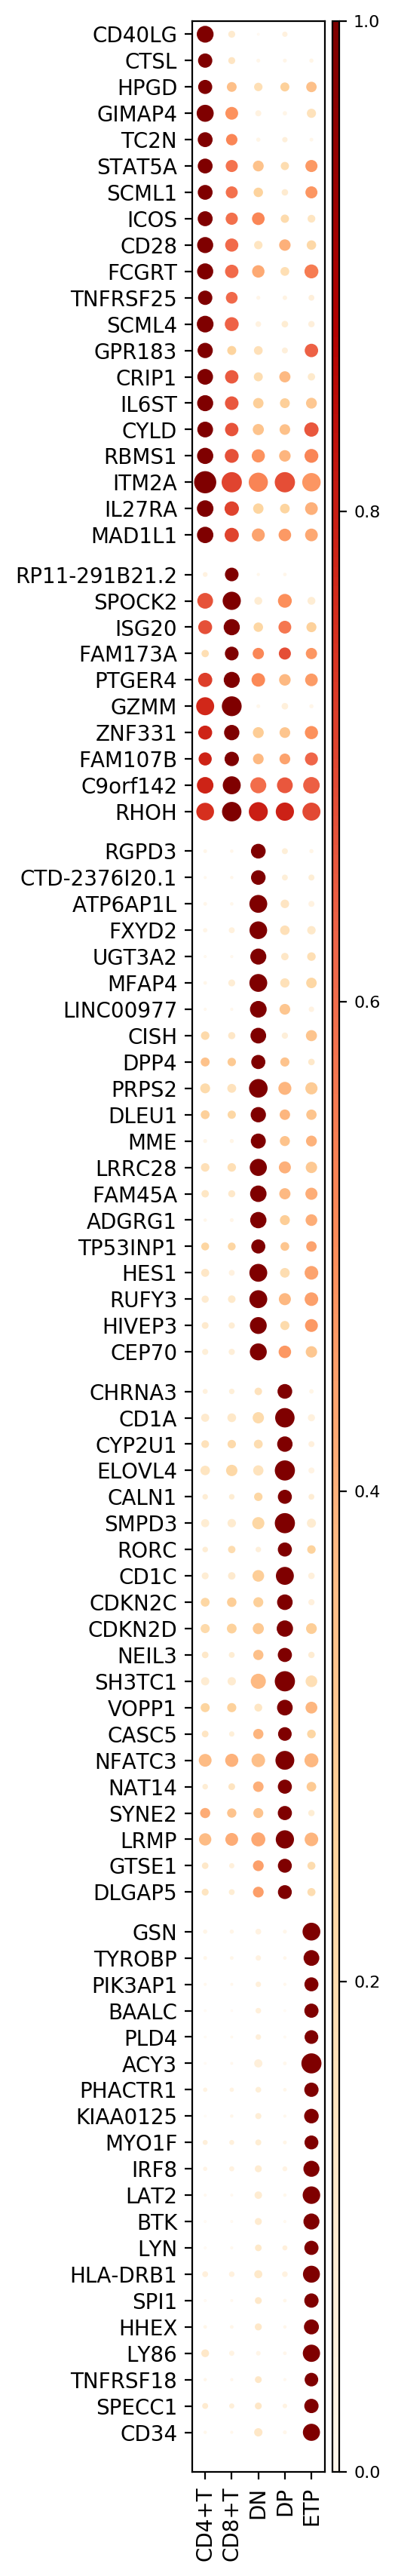

In [22]:
mk_genes_4 = scjp.markers.show_marker_plot(ndata_T,'Anno_level_4',mks_T_4,toshow=20)

In [23]:
ct_list = ['ETP','DN(P)','DN(Q)','DP(P)','DP(Q)','CD4+T','CD8+T']
ct_list = ['ETP','DN','DP','CD4+T','CD8+T']
gene_list = [items for sublist in [mk_genes_4[x]+[' '] for x in ct_list] for items in sublist][:-1]

In [24]:
ct_list = ['ETP','DN(P)','DN(Q)','DP(P)','DP(Q)','CD4+T','CD8+T']
gene_list = [items for sublist in [mk_genes_Staal[x]+[' '] for x in ct_list] for items in sublist][:-1]

In [25]:
ct_list

['ETP', 'DN(P)', 'DN(Q)', 'DP(P)', 'DP(Q)', 'CD4+T', 'CD8+T']

In [26]:
staal_genes = list(sdata.var_names)

02_Output/HTA08.v01.A07.Fig_Staal_geens.pdf


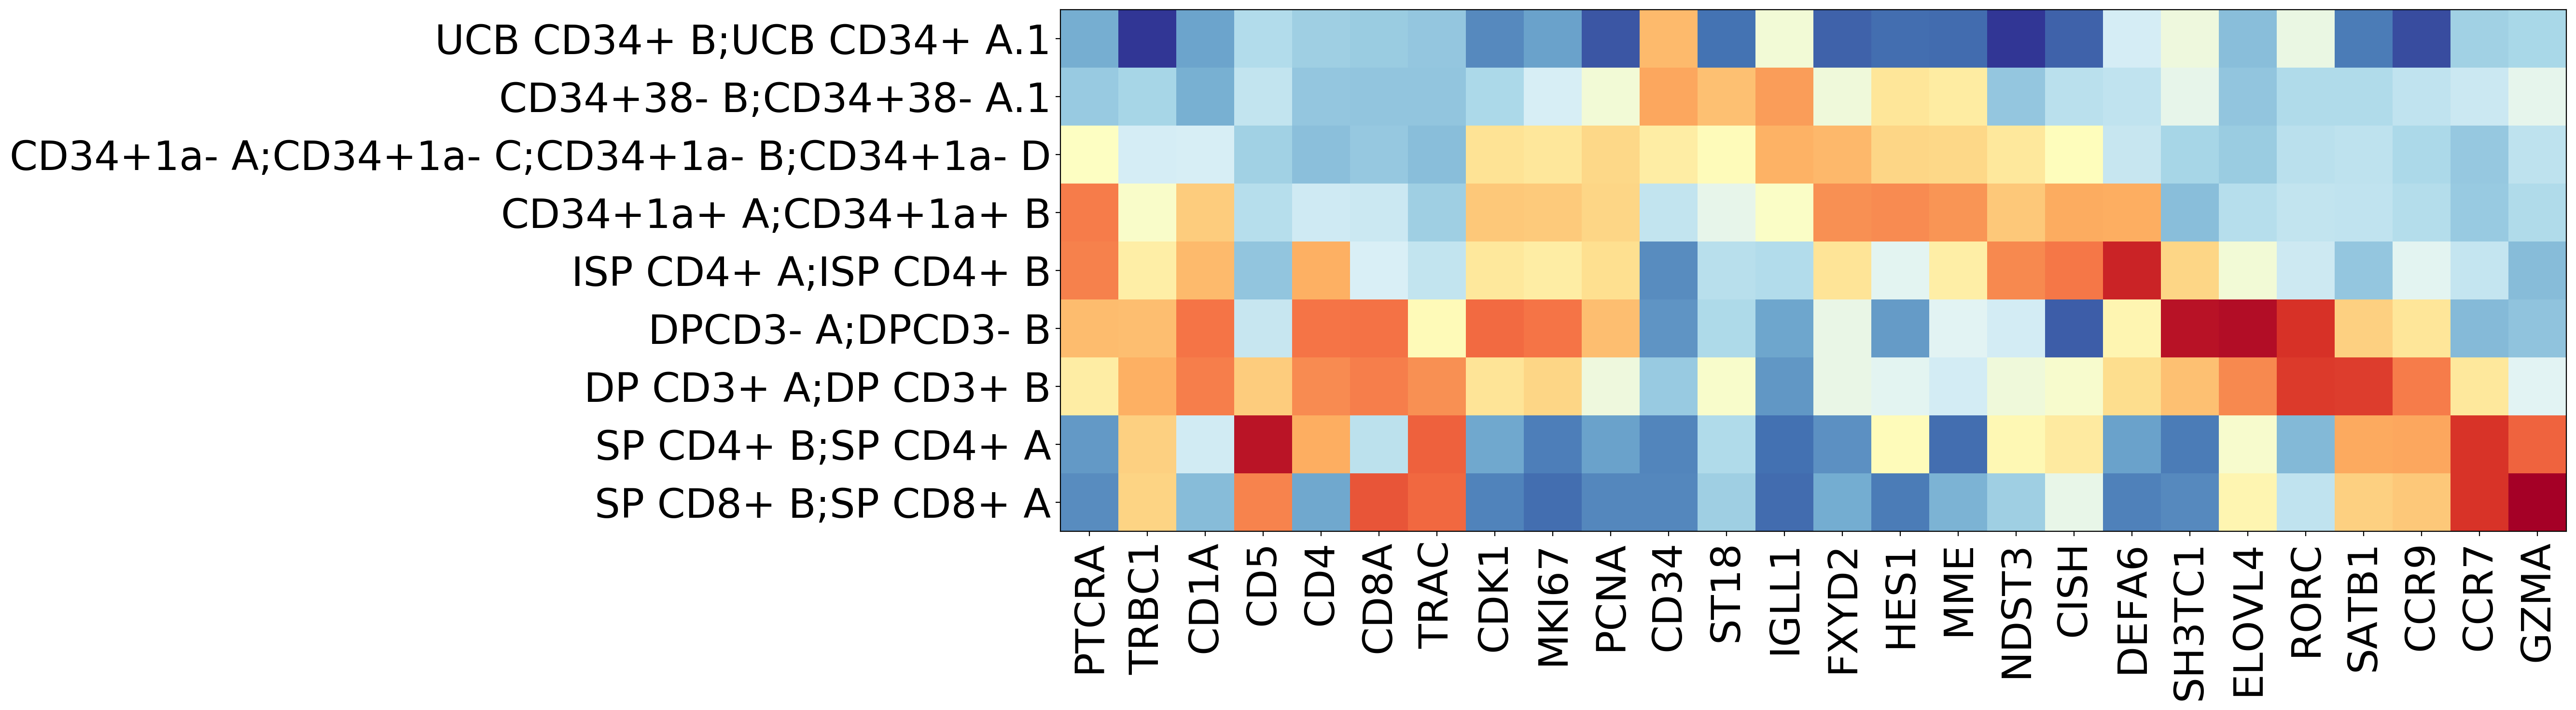

In [107]:
gene_list = ['PTCRA','TRBC1','CD1A','CD5','CD4','CD8A','TRAC','CDK1','MKI67','PCNA',
             'CD34','ST18','IGLL1','FXYD2','HES1','MME','NDST3','CISH','DEFA6',
            'SH3TC1','ELOVL4','RORC','SATB1','CCR9','CCR7','GZMA']

to_show = np.array([staal_genes.index(x) for x in gene_list if x in staal_genes])

fig = plt.figure(figsize=(20,10))

X = sdata.X[3:,to_show]

im = plt.imshow(X[::-1,:],cmap='RdYlBu_r',origin='lower')
xlabel = sdata.var_names[to_show]
ylabel = list(sdata.obs_names)[3:][::-1]
plt.xlim(-0.5,len(xlabel)-0.5)
plt.ylim(-0.5,len(ylabel)-0.5)
plt.xticks(range(len(xlabel)),xlabel,rotation=90,fontsize=30)
plt.yticks(range(len(ylabel)),ylabel,fontsize=30)
plt.grid(False)
scjp.jp_save_fig(version,'Fig_Staal_geens',fig_folder=fig_folder)

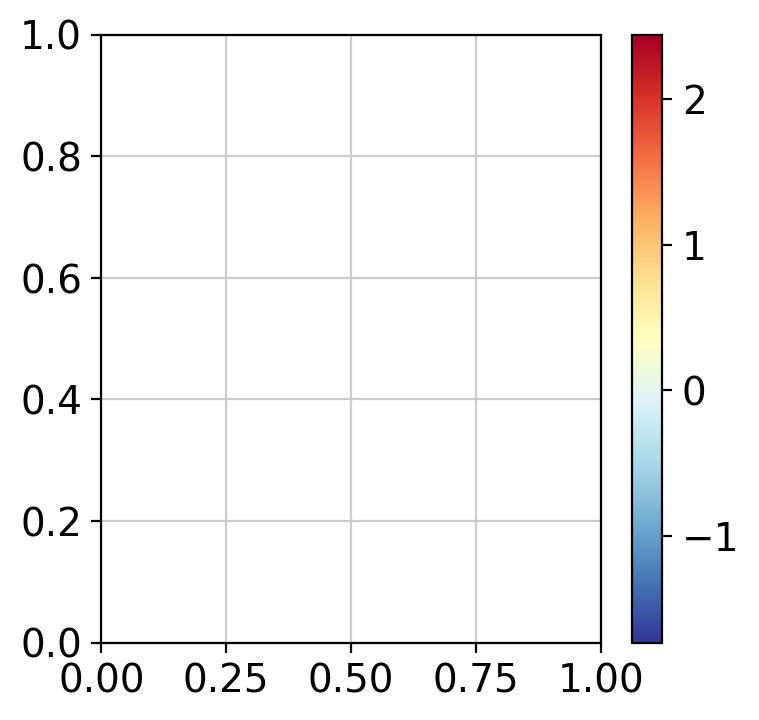

In [108]:
plt.colorbar(im)

02_Output/HTA08.v01.A07.Fig_Staal_geens.pdf


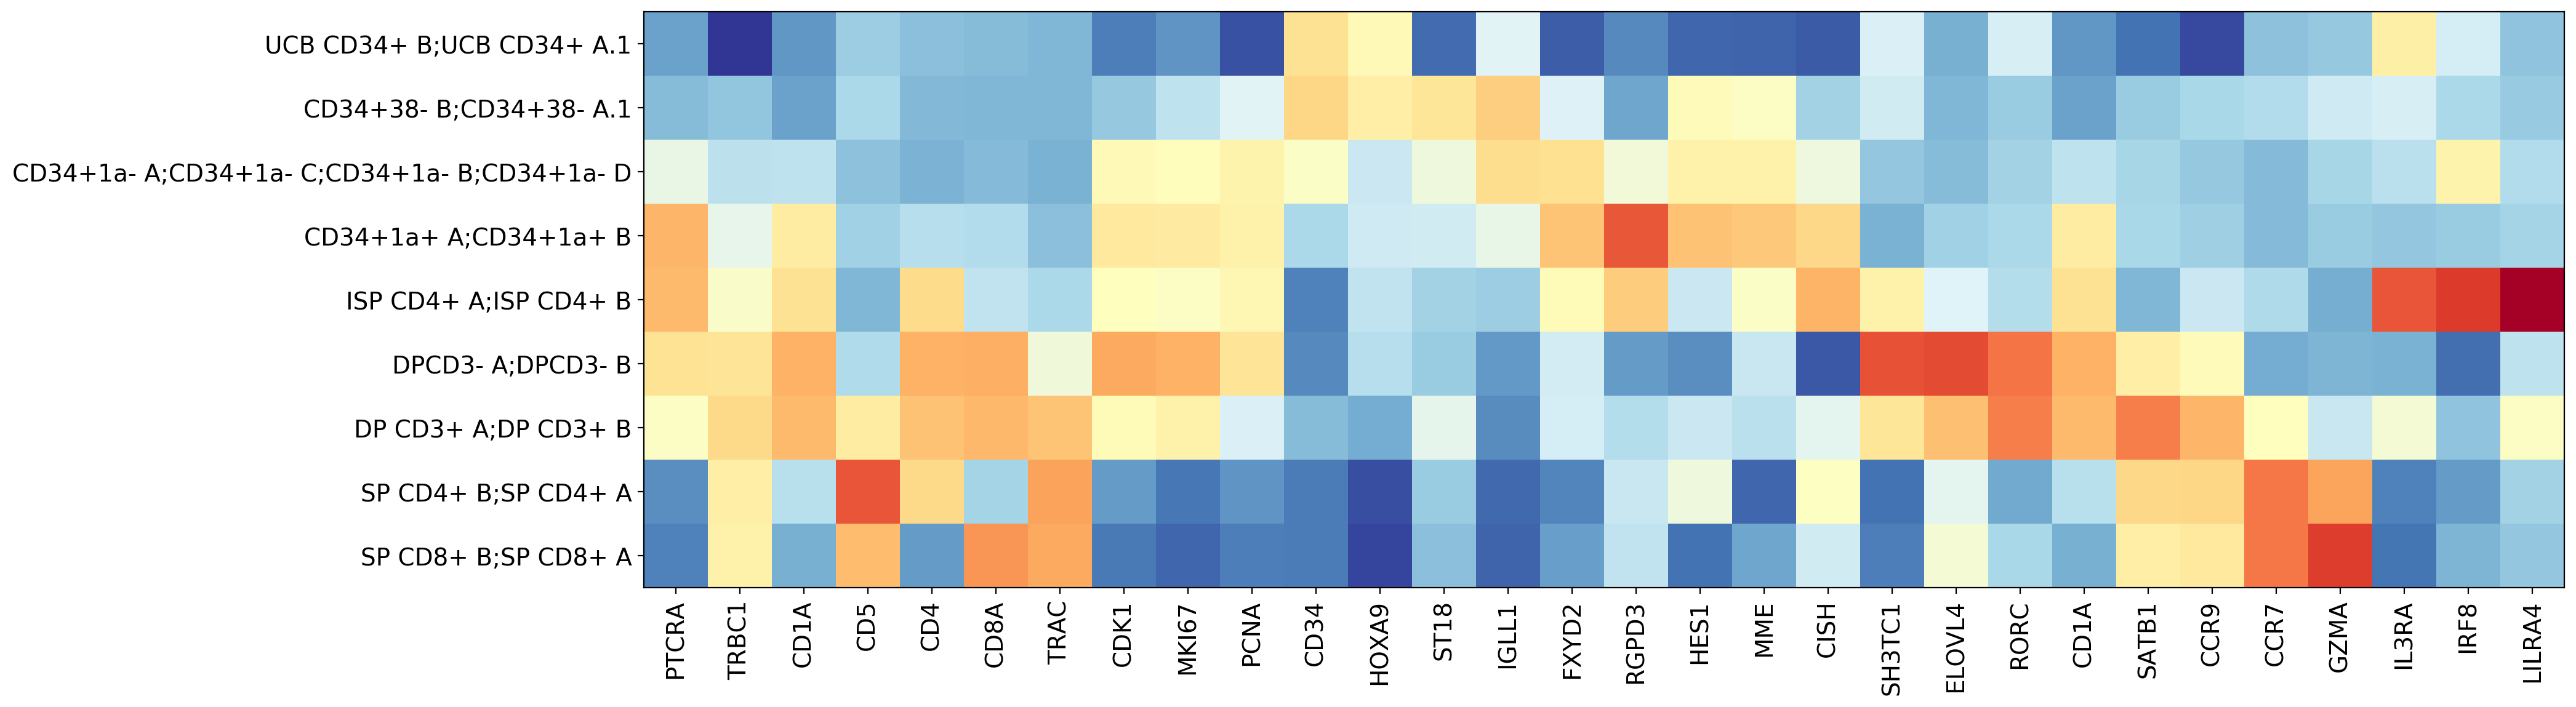

In [61]:
gene_list = ['PTCRA','TRBC1','CD1A','CD5','CD4','CD8A','TRAC','CDK1','MKI67','PCNA',
             'CD34','HOXA9','ST18','IGLL1','FXYD2','RGPD3','HES1','MME','CISH',
            'SH3TC1','ELOVL4','RORC','CD1A','SATB1','CCR9','CCR7','GZMA',
            'IL3RA','IRF8','LILRA4']

to_show = np.array([staal_genes.index(x) for x in gene_list if x in staal_genes])

plt.figure(figsize=(20,10))

X = sdata.X[3:,to_show]

plt.imshow(X[::-1,:],cmap='RdYlBu_r',origin='lower')
xlabel = sdata.var_names[to_show]
ylabel = list(sdata.obs_names)[3:][::-1]
plt.xlim(-0.5,len(xlabel)-0.5)
plt.ylim(-0.5,len(ylabel)-0.5)
plt.xticks(range(len(xlabel)),xlabel,rotation=90)
plt.yticks(range(len(ylabel)),ylabel)
plt.grid(False)
scjp.jp_save_fig(version,'Fig_Staal_geens',fig_folder=fig_folder)

In [63]:
sdata.obs_names

Index(['UCB CD34+ B;UCB CD34+ A', 'CD34+38- B;CD34+38- A',
       'CD34+1a- A;CD34+1a- C', 'UCB CD34+ B;UCB CD34+ A.1',
       'CD34+38- B;CD34+38- A.1',
       'CD34+1a- A;CD34+1a- C;CD34+1a- B;CD34+1a- D', 'CD34+1a+ A;CD34+1a+ B',
       'ISP CD4+ A;ISP CD4+ B', 'DPCD3- A;DPCD3- B', 'DP CD3+ A;DP CD3+ B',
       'SP CD4+ B;SP CD4+ A', 'SP CD8+ B;SP CD8+ A'],
      dtype='object')

In [67]:
sdata.var_names

Index(['A1CF', 'A2M', 'A4GALT', 'A4GNT', 'AAAS', 'AACS', 'AADAC', 'AAGAB',
       'AAK1', 'AAMDC',
       ...
       'ZSWIM8-AS1', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=13759)

In [ ]:
DEFA6, CISH, NDST3, P2RX5-TAX1BP3, RGPD3, PCBP3, 

In [91]:
genes = sdata.var_names[np.argsort(-sdata.X[7,:])][500:600]

/mnt/thymus_atlas/scjp/markers.py:442: RuntimeWarning:

invalid value encountered in true_divide



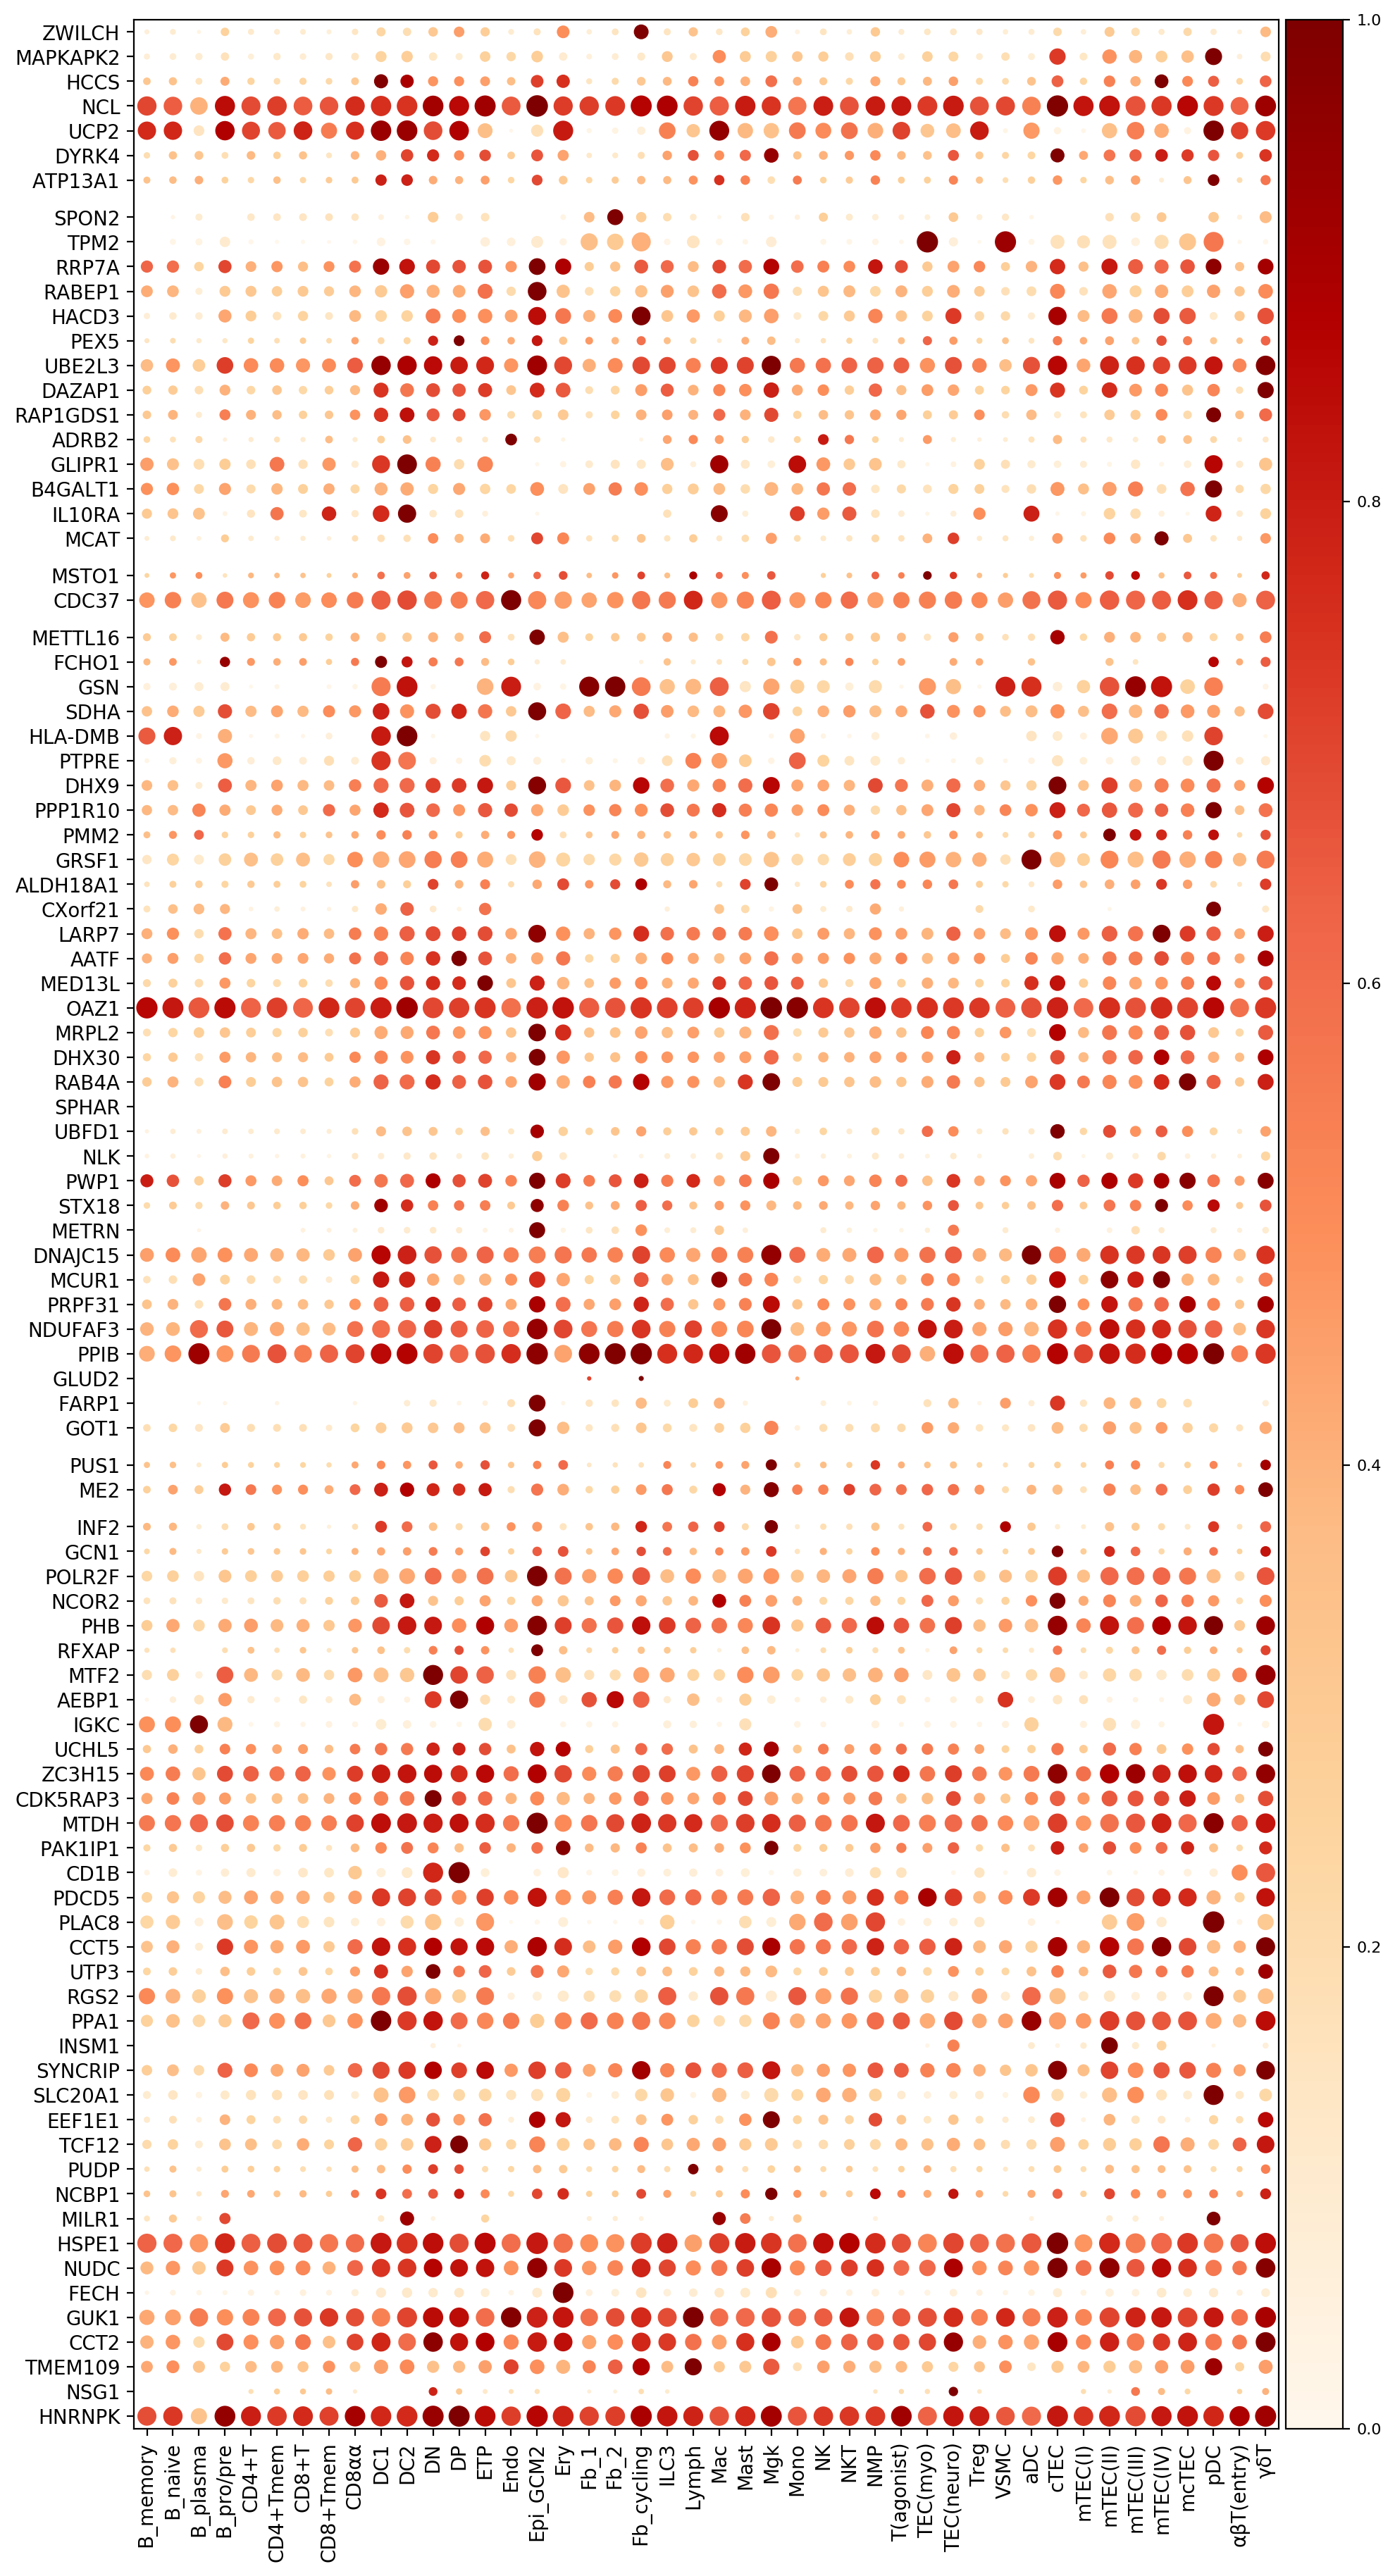

In [92]:
markers.draw_marker_blob_v2(ndata,ndata.uns['cdm_Anno_level_fig1'],genes)

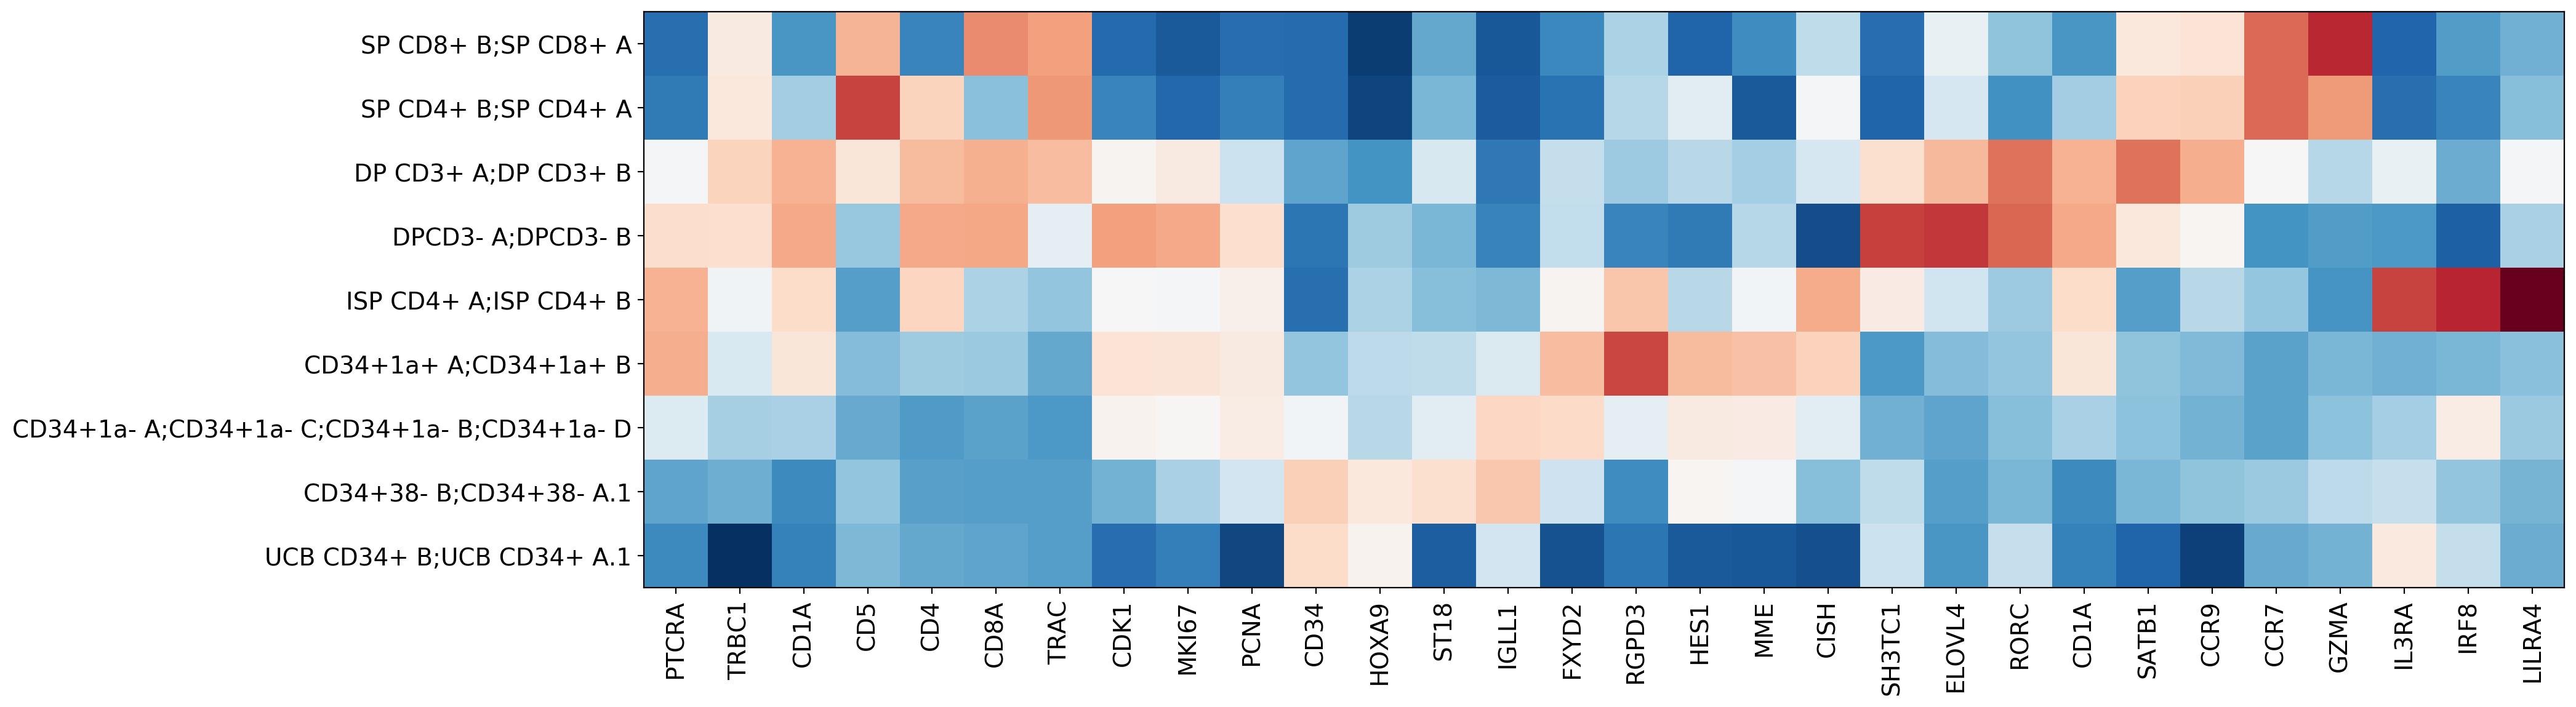

In [62]:
to_show = np.array([staal_genes.index(x) for x in gene_list if x in staal_genes])

plt.figure(figsize=(20,10))
plt.imshow(sdata.X[3:,to_show],cmap='RdBu_r')
xlabel = sdata.var_names[to_show]
ylabel = list(sdata.obs_names)[3:]
plt.xlim(-0.5,len(xlabel)-0.5)
plt.ylim(-0.5,len(ylabel)-0.5)
plt.xticks(range(len(xlabel)),xlabel,rotation=90)
plt.yticks(range(len(ylabel)),ylabel)
plt.grid(False)
plt.show()

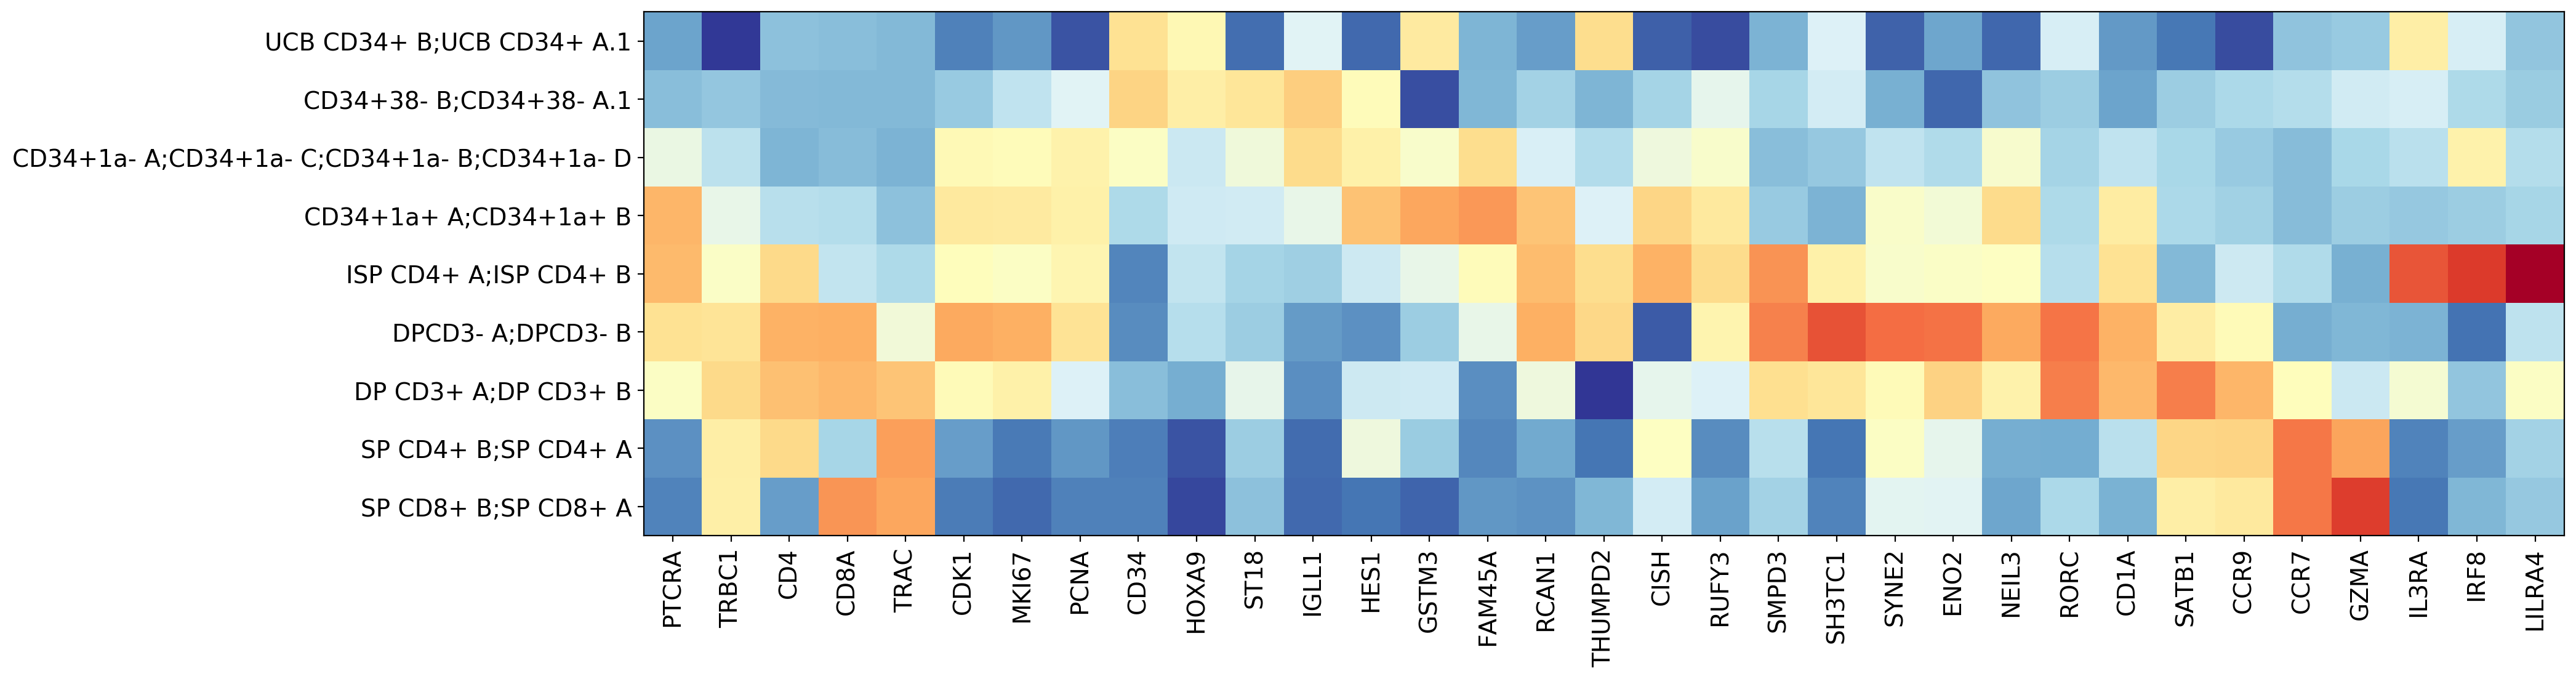

In [41]:
gene_list = ['PTCRA','TRBC1','CD4','CD8A','TRAC','CDK1','MKI67','PCNA',
             'CD34','HOXA9','ST18','IGLL1','HES1','GSTM3','FAM45A','RCAN1','THUMPD2','CISH','LRRC28','RUFY3','SMPD3',
             'SH3TC1','SYNE2','ENO2','NEIL3','RORC','CD1A','SATB1','CCR9','CCR7','GZMA',
            'IL3RA','IRF8','LILRA4']

to_show = np.array([staal_genes.index(x) for x in gene_list if x in staal_genes])

plt.figure(figsize=(20,10))

X = sdata.X[3:,to_show]

plt.imshow(X[::-1,:],cmap='RdYlBu_r',origin='lower')
xlabel = sdata.var_names[to_show]
ylabel = list(sdata.obs_names)[3:][::-1]
plt.xlim(-0.5,len(xlabel)-0.5)
plt.ylim(-0.5,len(ylabel)-0.5)
plt.xticks(range(len(xlabel)),xlabel,rotation=90)
plt.yticks(range(len(ylabel)),ylabel)
plt.grid(False)
plt.show()

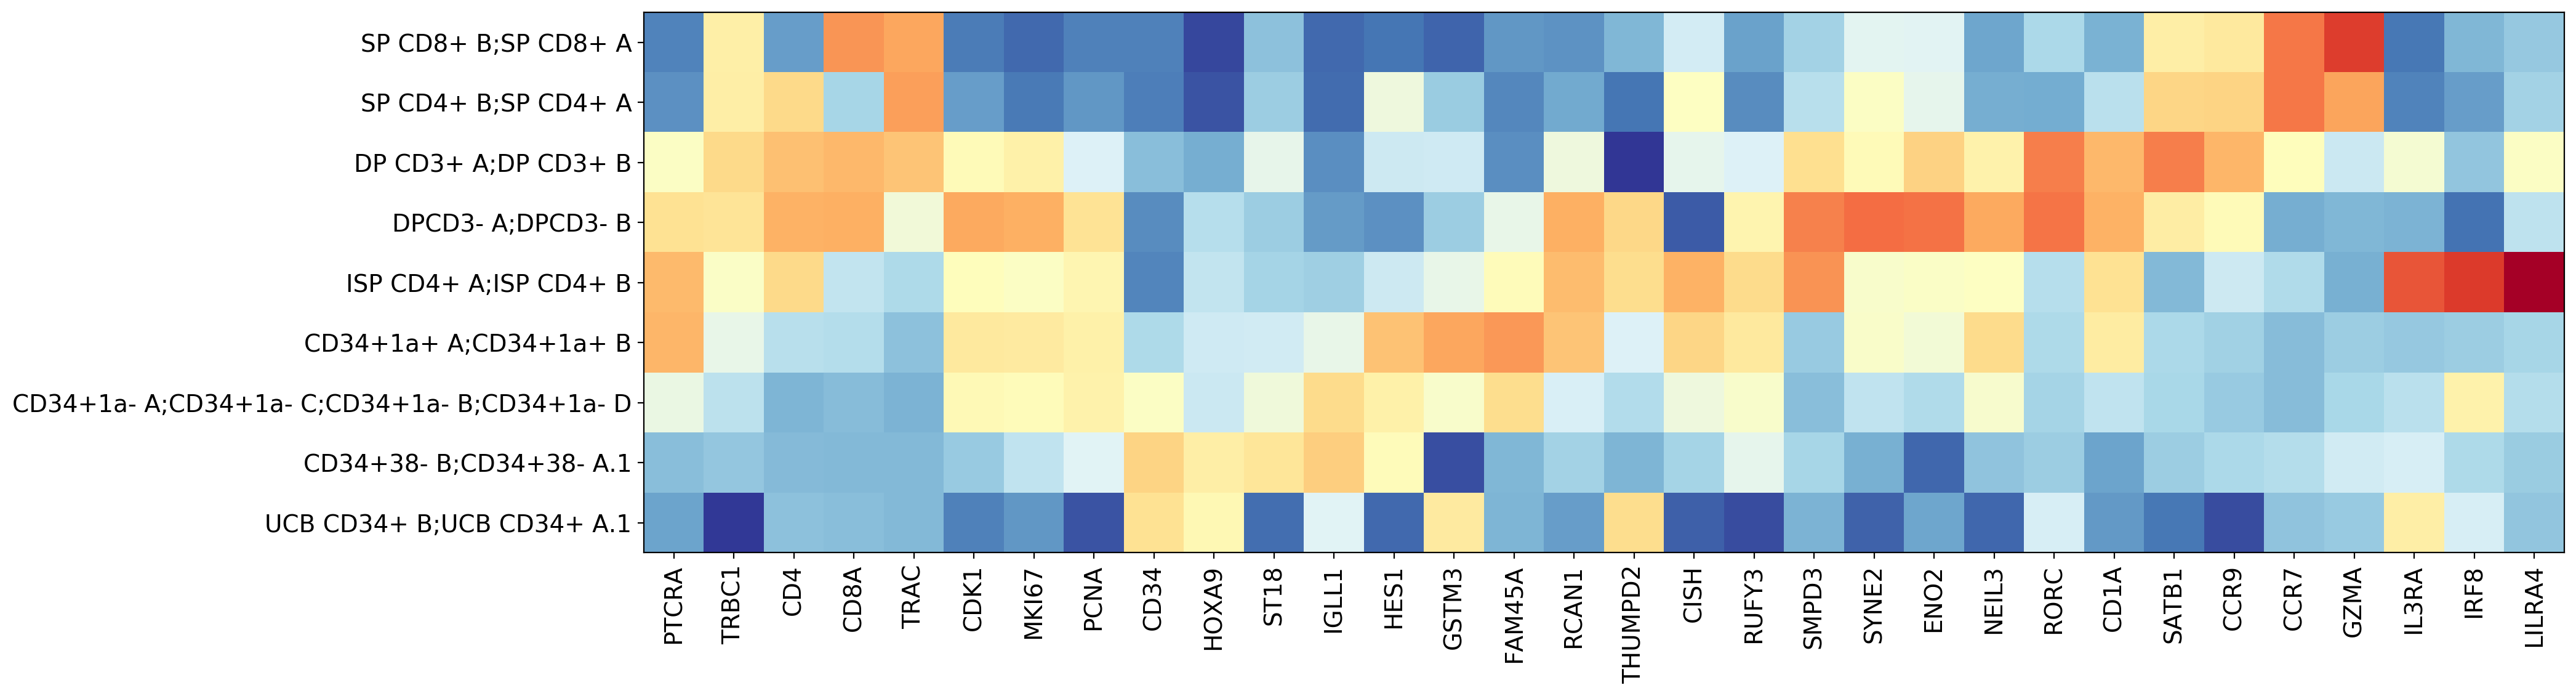

In [34]:
gene_list = ['PTCRA','TRBC1','CD4','CD8A','TRAC','CDK1','MKI67','PCNA',
             'CD34','HOXA9','ST18','IGLL1','HES1','GSTM3','FAM45A','RCAN1','THUMPD2','CISH','LRRC28','RUFY3','SMPD3',
             'SYNE2','ENO2','NEIL3','RORC','CD1A','SATB1','CCR9','CCR7','GZMA',
            'IL3RA','IRF8','LILRA4']

to_show = np.array([staal_genes.index(x) for x in gene_list if x in staal_genes])

plt.figure(figsize=(20,10))
plt.imshow(sdata.X[3:,to_show],cmap='RdYlBu_r')
xlabel = sdata.var_names[to_show]
ylabel = list(sdata.obs_names)[3:]
plt.xlim(-0.5,len(xlabel)-0.5)
plt.ylim(-0.5,len(ylabel)-0.5)
plt.xticks(range(len(xlabel)),xlabel,rotation=90)
plt.yticks(range(len(ylabel)),ylabel)
plt.grid(False)
plt.show()

In [30]:
mdata_order = ['ETP','DN(early)','DN(P)','DN(Q)','DP(P)', 'DP(Q)','αβT(entry)','CD4+T', 'CD8+T', 'pDC']

In [31]:
mdata_show = mdata[mdata_order]

jp_genes = list(mdata_show.var_names)

to_show = np.array([jp_genes.index(x) for x in gene_list if x in jp_genes])

plt.figure(figsize=(20,10))
plt.imshow(mdata_show.X[:,to_show],cmap='RdYlBu_r')
xlabel = mdata_show.var_names[to_show]
ylabel = list(mdata_show.obs_names)
plt.xticks(range(len(xlabel)),xlabel,rotation=90)
plt.yticks(range(len(ylabel)),ylabel)
plt.grid(False)
plt.show()

NameError: name 'mdata' is not defined

In [905]:
exclude = ["T_memory",'Ery','Endo','Fb','Lymph','Mgk',
           'Mast','TEC(myo)','TEC(neuro)','cTEC','mTEC',
           'VSMC','Mac','Mono','Tuncv','aDC','NK','ILC3',
          ]

In [906]:
ndata_partial = ndata[~ndata.obs['Anno_level_Staal'].isin(exclude)].copy()

In [907]:
mks_multi = scjp.markers.find_markers(ndata_partial,'Anno_level_Staal',min_drop_cut=0.1,min_mean_cut=0,thres=0.2,single=False)

In [908]:
mks_single = scjp.markers.find_markers(ndata_partial,'Anno_level_Staal',min_drop_cut=0.1,min_mean_cut=0,thres=0.2,single=True)

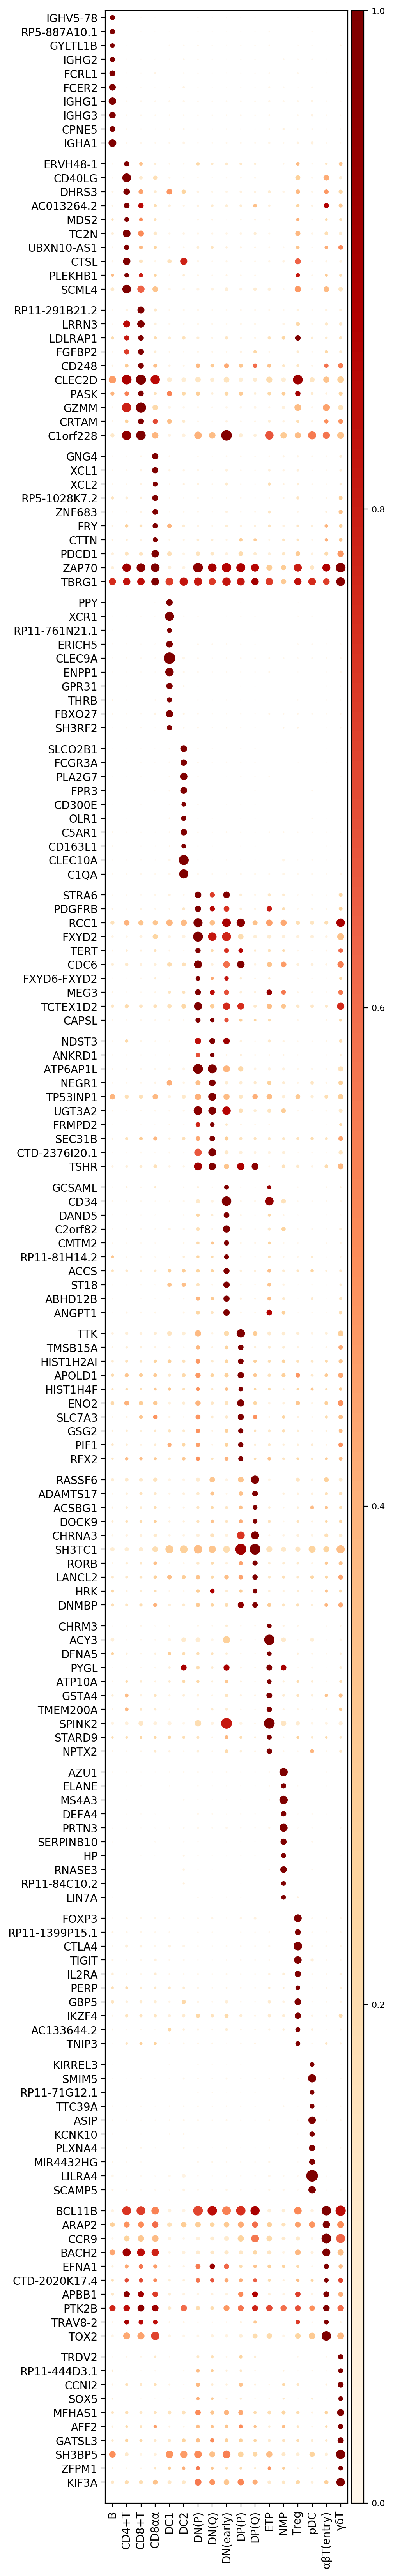

In [909]:
mk_genes = scjp.markers.show_marker_plot(ndata_partial,'Anno_level_Staal',mks_multi)

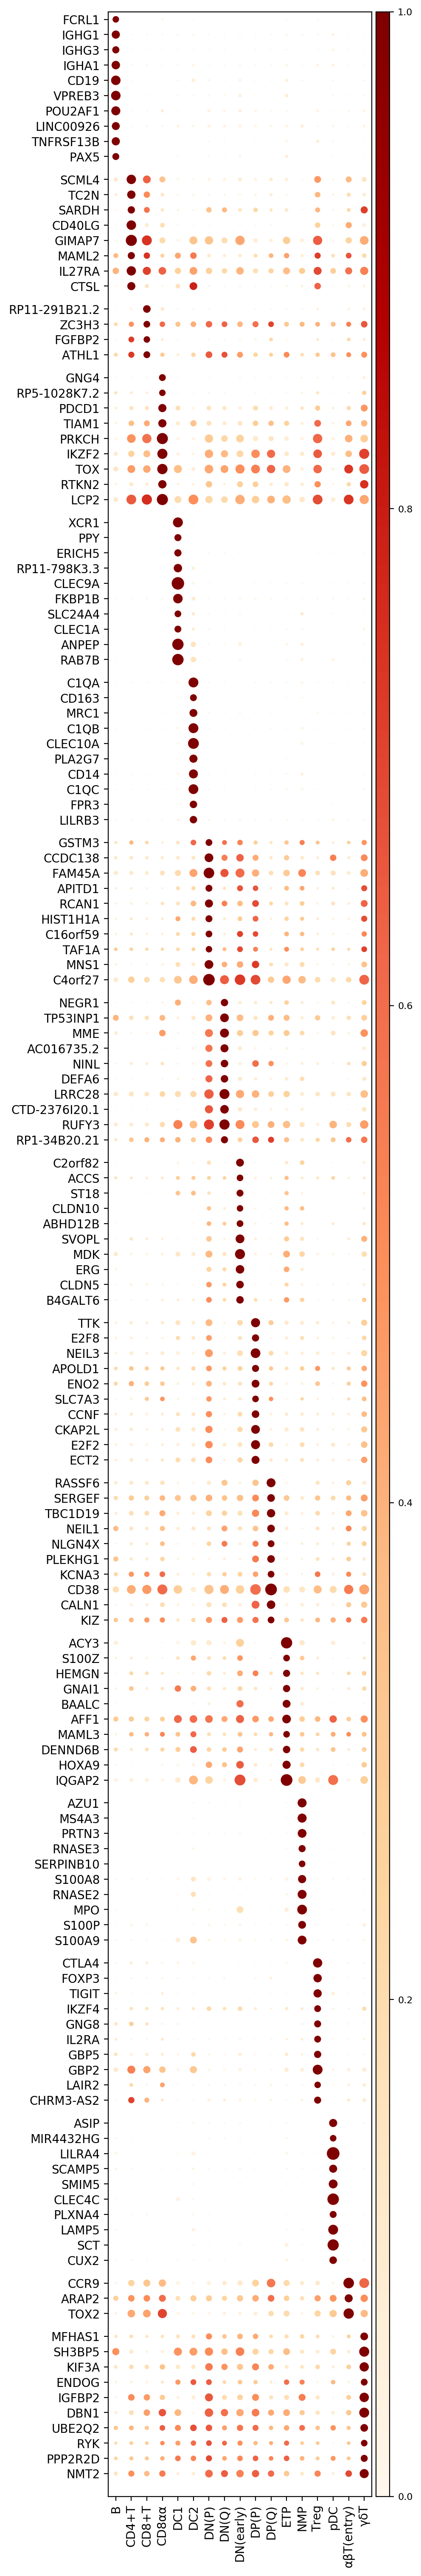

In [910]:
mk_genes = scjp.markers.show_marker_plot(ndata_partial,'Anno_level_Staal',mks)

In [918]:
variable_genes = [items for sublist in mk_genes.values() for items in sublist]

In [919]:
set(ndata_common.obs['Anno_level_Staal'
                    ])

{'CD4+T',
 'CD8+T',
 'CD8αα',
 'DN(P)',
 'DN(Q)',
 'DN(early)',
 'DP(P)',
 'DP(Q)',
 'ETP',
 'pDC',
 'αβT(entry)',
 'γδT'}

In [920]:
raw = sc.AnnData(ndata_partial.raw.X)
raw.var = ndata_partial.raw.var
raw.obs = ndata_partial.obs

In [921]:
train = model.generate_training_X(raw,'Anno_level_Staal',select_num=200)

In [922]:
sc.pp.filter_genes_dispersion(train)

Trying to set attribute `.var` of view, making a copy.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [923]:
scjp.remove_geneset(train,scjp.cc_genes)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 3400 × 2608 
    obs: 'Sample', 'n_counts', 'n_genes', 'donor', 'organ', 'sort', 'method', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'source', 'birth', 'batch', 'bbk', 'Order', 'File', 'Age', 'Enzyme', 'Source', 'Stage', 'Stage2', 'scrublet_doublets', 'is_Fig1', 'is_file_Fig1', 'true_doublets', 'missed_doublets_scbl', 'missed_doublets_jp', 'anno_doublet_4_scores', 'anno_doublet_5_scores', 'anno_doublet_6_scores', 'anno_doublet_7_scores', 'anno_doublet_8_scores', 'anno_doublet_T_scores', 'dbl_jp_method', 'broad_doublets', 'anno_pred', 'anno_fig1_detailed.replaced.1', 'anno_predict_B.replaced.1', 'Cycle_score', 'isCycle', 'anno_predict_fig1.replaced.1', 'anno_fig1_detailed.replaced.2', 'anno_fig1_detailed', 'anno_predict_B.replaced.2', 'anno_predict_B', 'anno_predict_fig1.replaced.2', 'anno_predict_fig1', 'anno_final_v1', 'anno_final_v2_epi', 'donor_method', 'Anno_level_1', 'Anno_level_2', 'Anno_level_3', 'Anno_level_4', 'Anno_le

In [924]:
variable_genes2 = train.var_names

In [761]:
sdata_markers = sdata[:,sdata.var_names.isin(list(variable_genes)+list(variable_genes2))]

In [762]:
sdata_markers.raw = sdata_markers

## all genes version (optional)

In [925]:
sdata_markers = sdata[:,~sdata.var_names.isin(scjp.cc_genes)]
sdata_markers.raw = sdata_markers

## Get common genes

In [926]:
ndata_common, sdata_common = scjp.model.get_common_var_raw(ndata_partial,sdata_markers)

calculating a...
calculating b...


In [927]:
sc.pp.scale(sdata_common,max_value=10)
sc.pp.scale(ndata_common,max_value=10)

creating lr model...


/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



making lr prediction...
updating lr to adata...


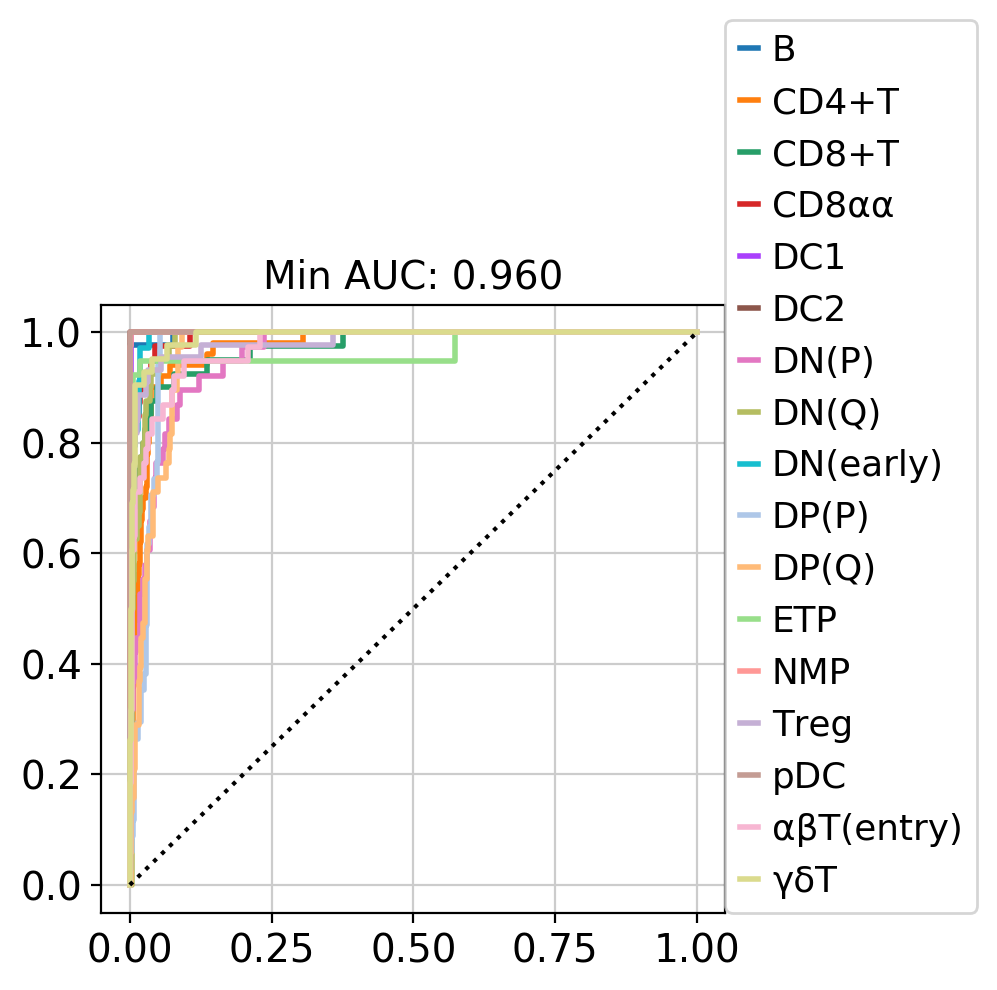

In [928]:
lr2 = scjp.model.transfer_annotation_jp(ndata_common,'Anno_level_Staal',sdata_common,'prediction',raw=False)

In [929]:
proba = lr2.predict_proba(sdata_common.X)

In [930]:
sdata_common.obs['prediction']

UCB CD34+ B;UCB CD34+ A                              ETP
CD34+38- B;CD34+38- A                              DP(P)
CD34+1a- A;CD34+1a- C                          DN(early)
UCB CD34+ B;UCB CD34+ A.1                            ETP
CD34+38- B;CD34+38- A.1                        DN(early)
CD34+1a- A;CD34+1a- C;CD34+1a- B;CD34+1a- D    DN(early)
CD34+1a+ A;CD34+1a+ B                              DN(P)
ISP CD4+ A;ISP CD4+ B                              DP(P)
DPCD3- A;DPCD3- B                                  DP(P)
DP CD3+ A;DP CD3+ B                                  DC2
SP CD4+ B;SP CD4+ A                                CD4+T
SP CD8+ B;SP CD8+ A                                CD8+T
Name: prediction, dtype: object

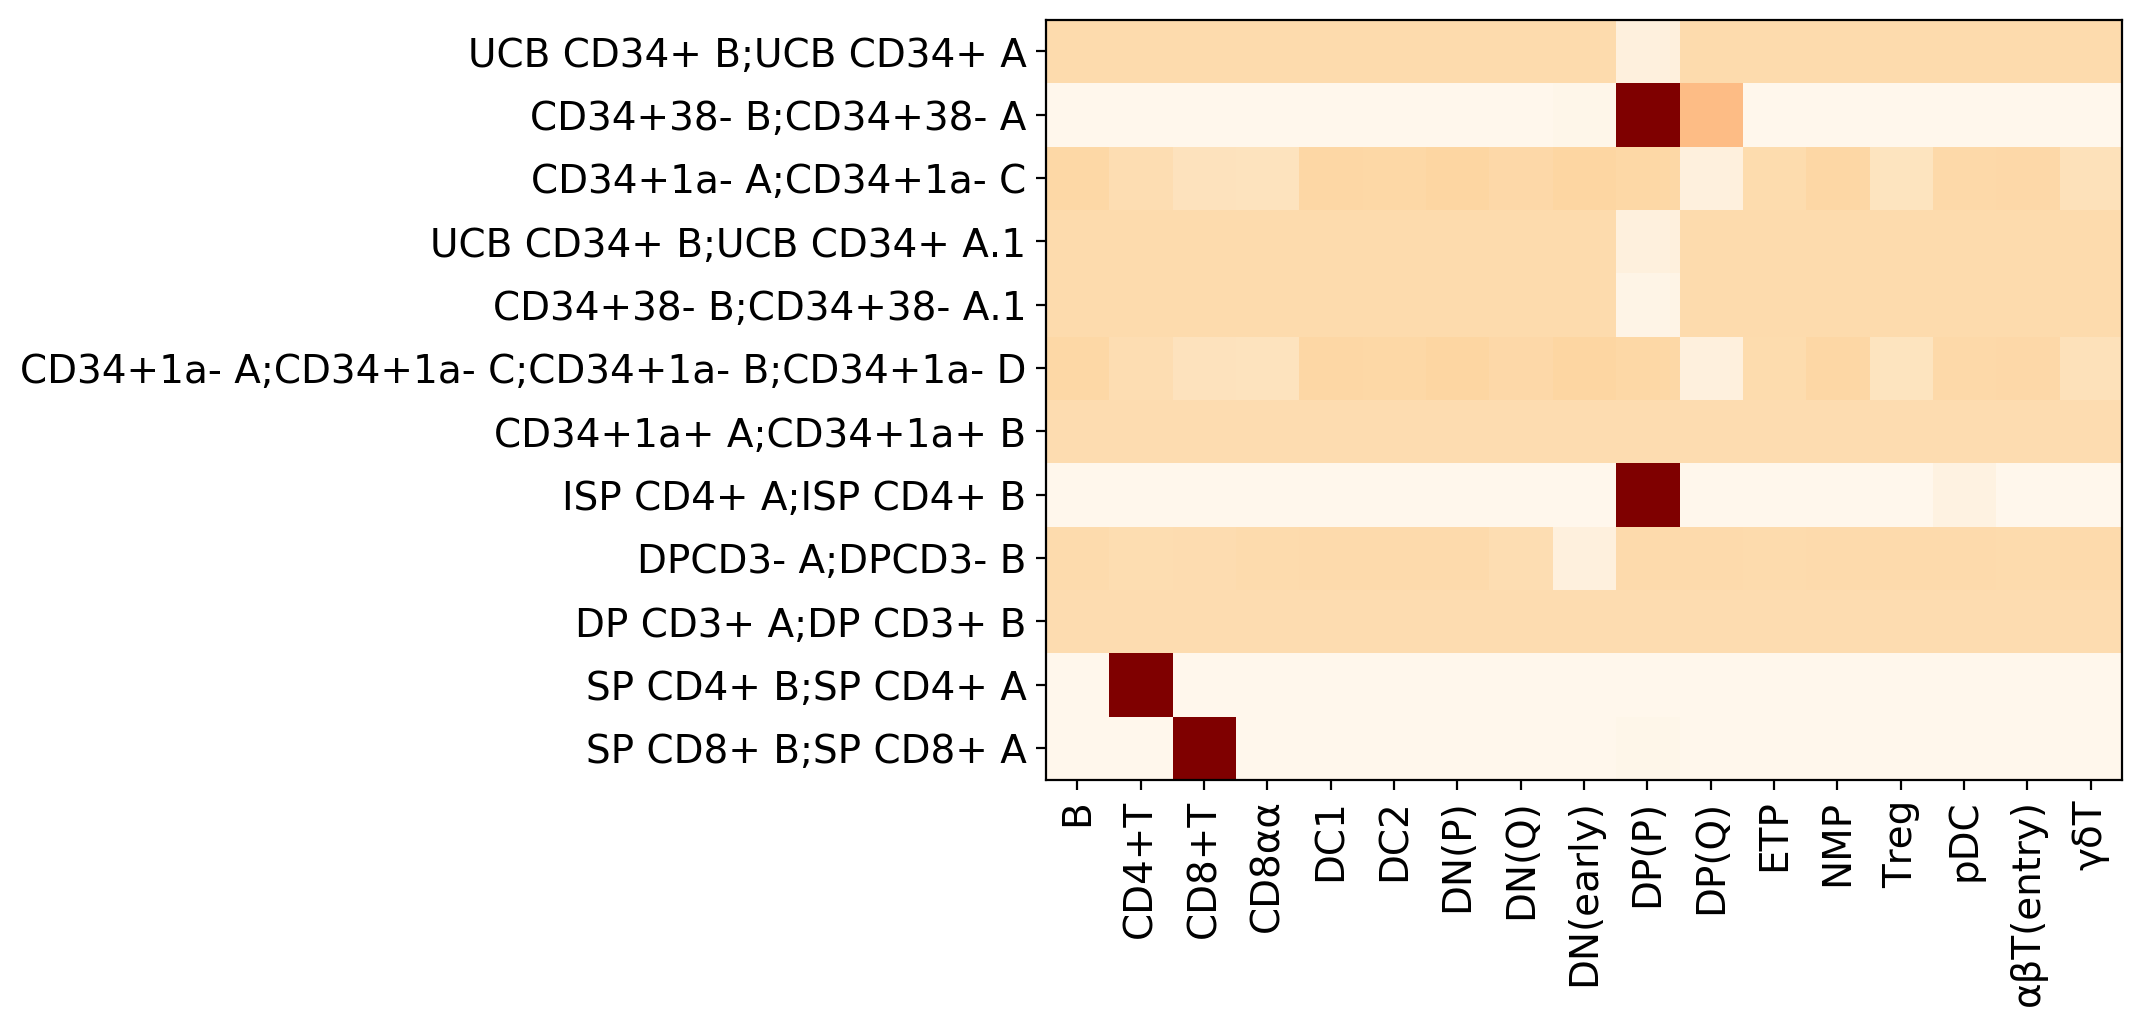

In [931]:
plt.figure(figsize=(10,5))
plt.imshow(proba,vmax=0.3)
xlabel = list(lr2.classes_)
ylabel = list(sdata_common.obs_names)
plt.xticks(range(len(xlabel)),xlabel,rotation=90)
plt.yticks(range(len(ylabel)),ylabel)
plt.grid(False)
plt.show()

In [932]:
from sklearn.preprocessing import MinMaxScaler

In [933]:
m_stack = []

for i,ct in enumerate(lr2.coef_):
    p = np.mean(sdata_common.X[:,np.argsort(-lr2.coef_[i])[:50]],axis=1)
    n = np.mean(sdata_common.X[:,np.argsort(lr2.coef_[i])[:50]],axis=1)
    
    m_stack.append(p-n)
    
scores = np.vstack(m_stack).T
scores_scaled = MinMaxScaler().fit_transform(scores)

In [934]:
x_order = ['ETP', 'DN(early)', 'DN(P)', 'DN(Q)', 'DP(P)', 'DP(Q)',
       'αβT(entry)', 'CD4+T', 'CD8+T', 'pDC']

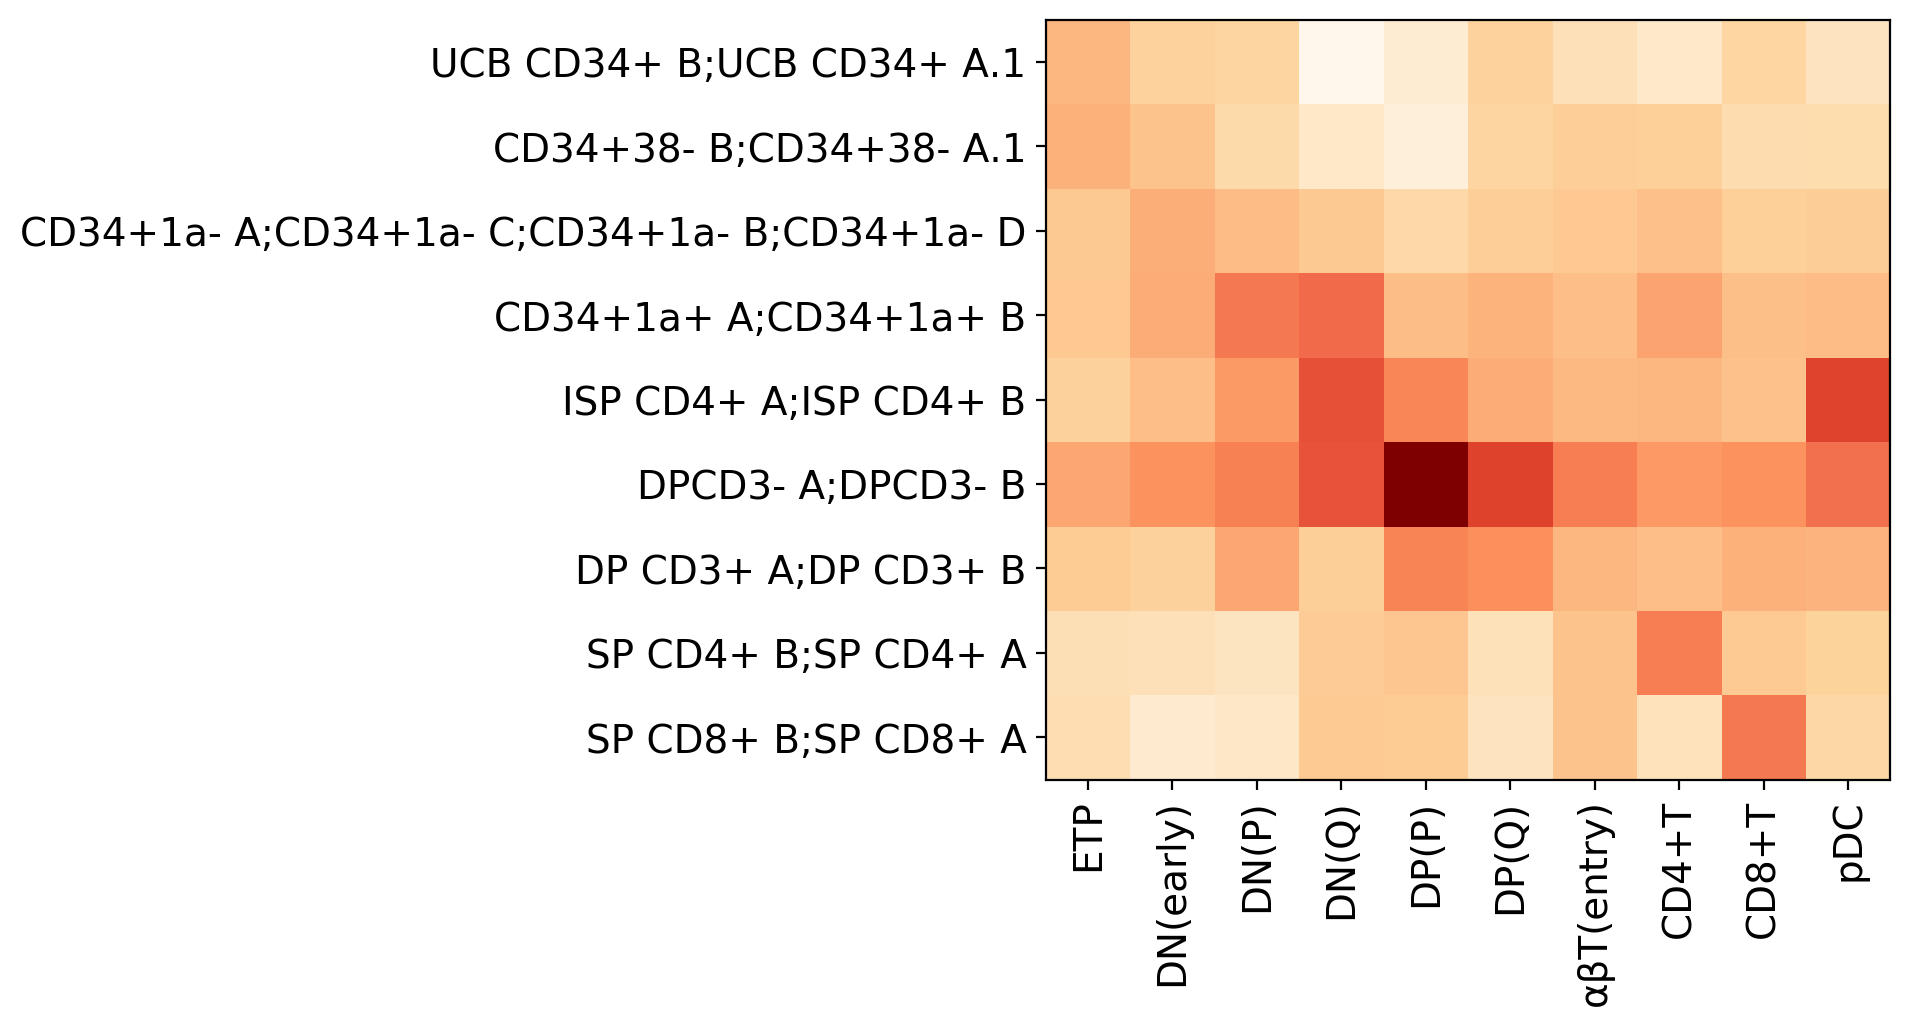

In [935]:
x_index = np.array([list(lr2.classes_).index(x) for x in x_order])

plt.figure(figsize=(10,5))
plt.imshow(scores[3:,x_index])
xlabel = np.array(lr2.classes_)[x_index]
ylabel = list(sdata_common.obs_names)[3:]
plt.xticks(range(len(xlabel)),xlabel,rotation=90)
plt.yticks(range(len(ylabel)),ylabel)
plt.grid(False)
plt.show()

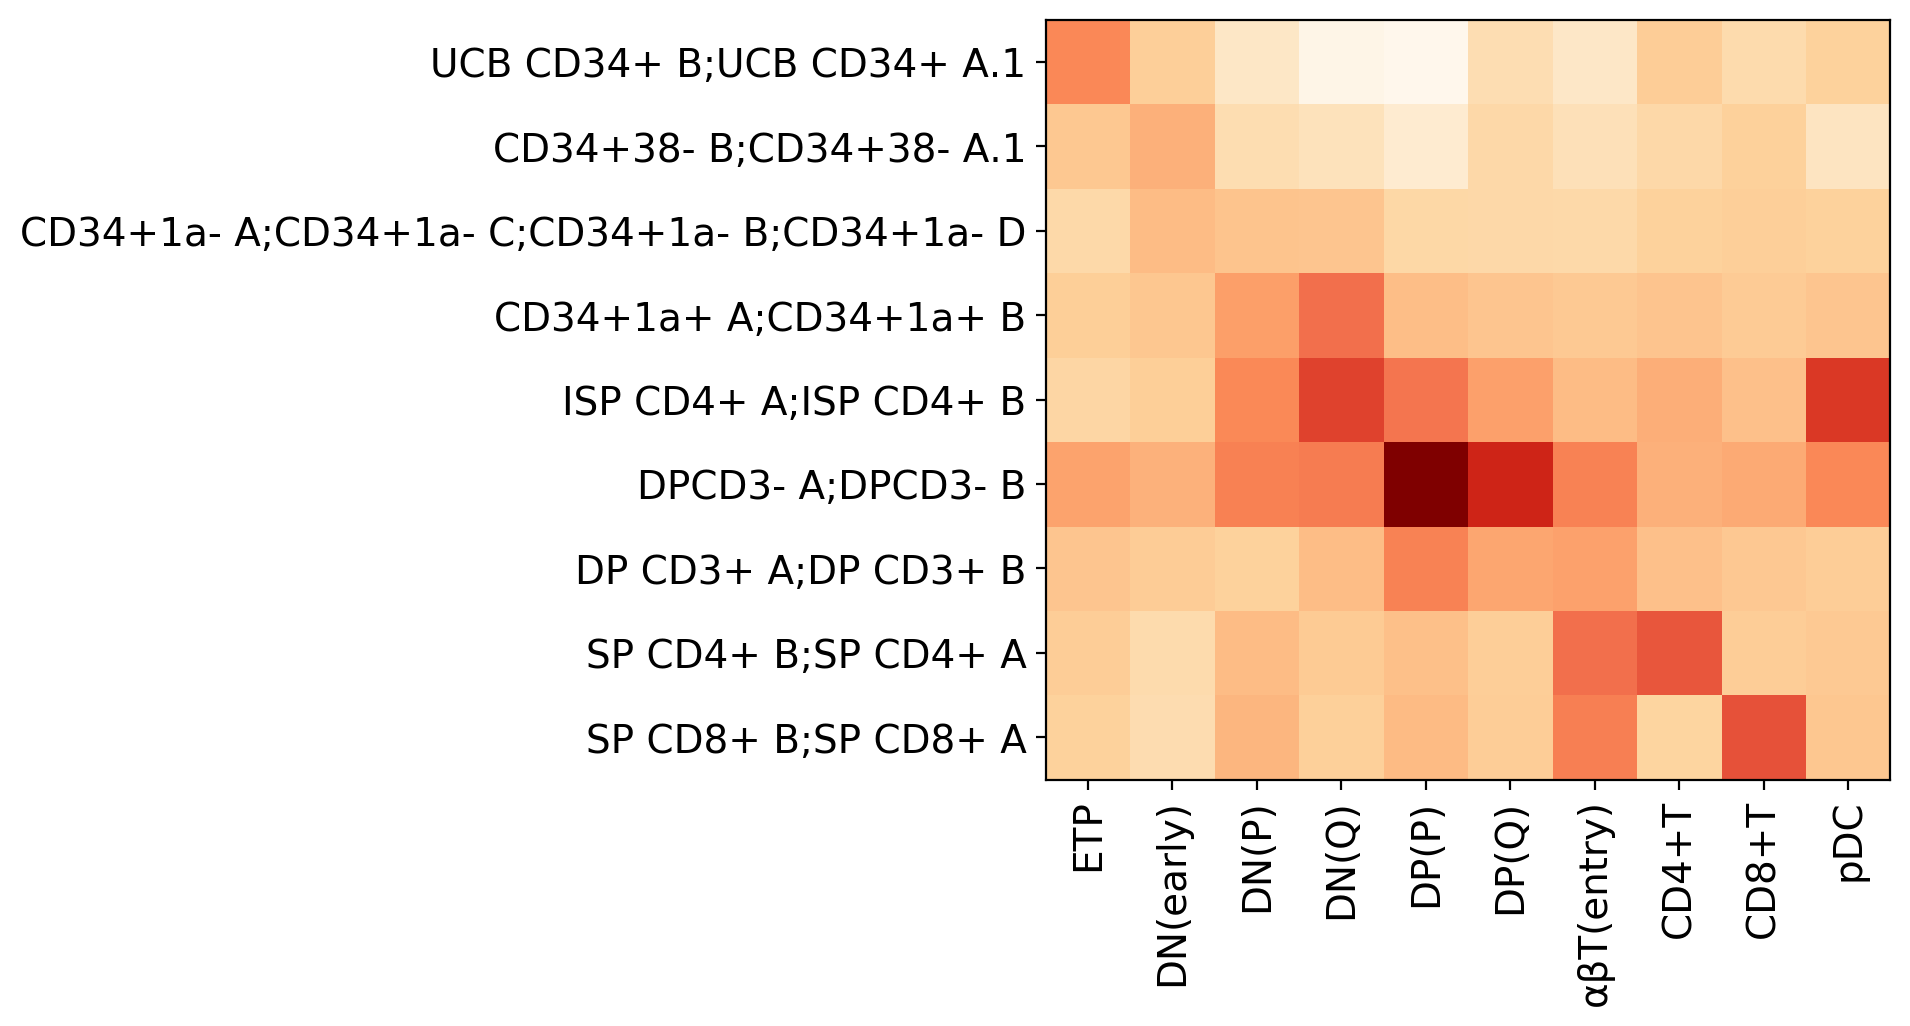

In [811]:
x_index = np.array([list(lr2.classes_).index(x) for x in x_order])

plt.figure(figsize=(10,5))
plt.imshow(scores[3:,x_index])
xlabel = np.array(lr2.classes_)[x_index]
ylabel = list(sdata_common.obs_names)[3:]
plt.xticks(range(len(xlabel)),xlabel,rotation=90)
plt.yticks(range(len(ylabel)),ylabel)
plt.grid(False)
plt.show()

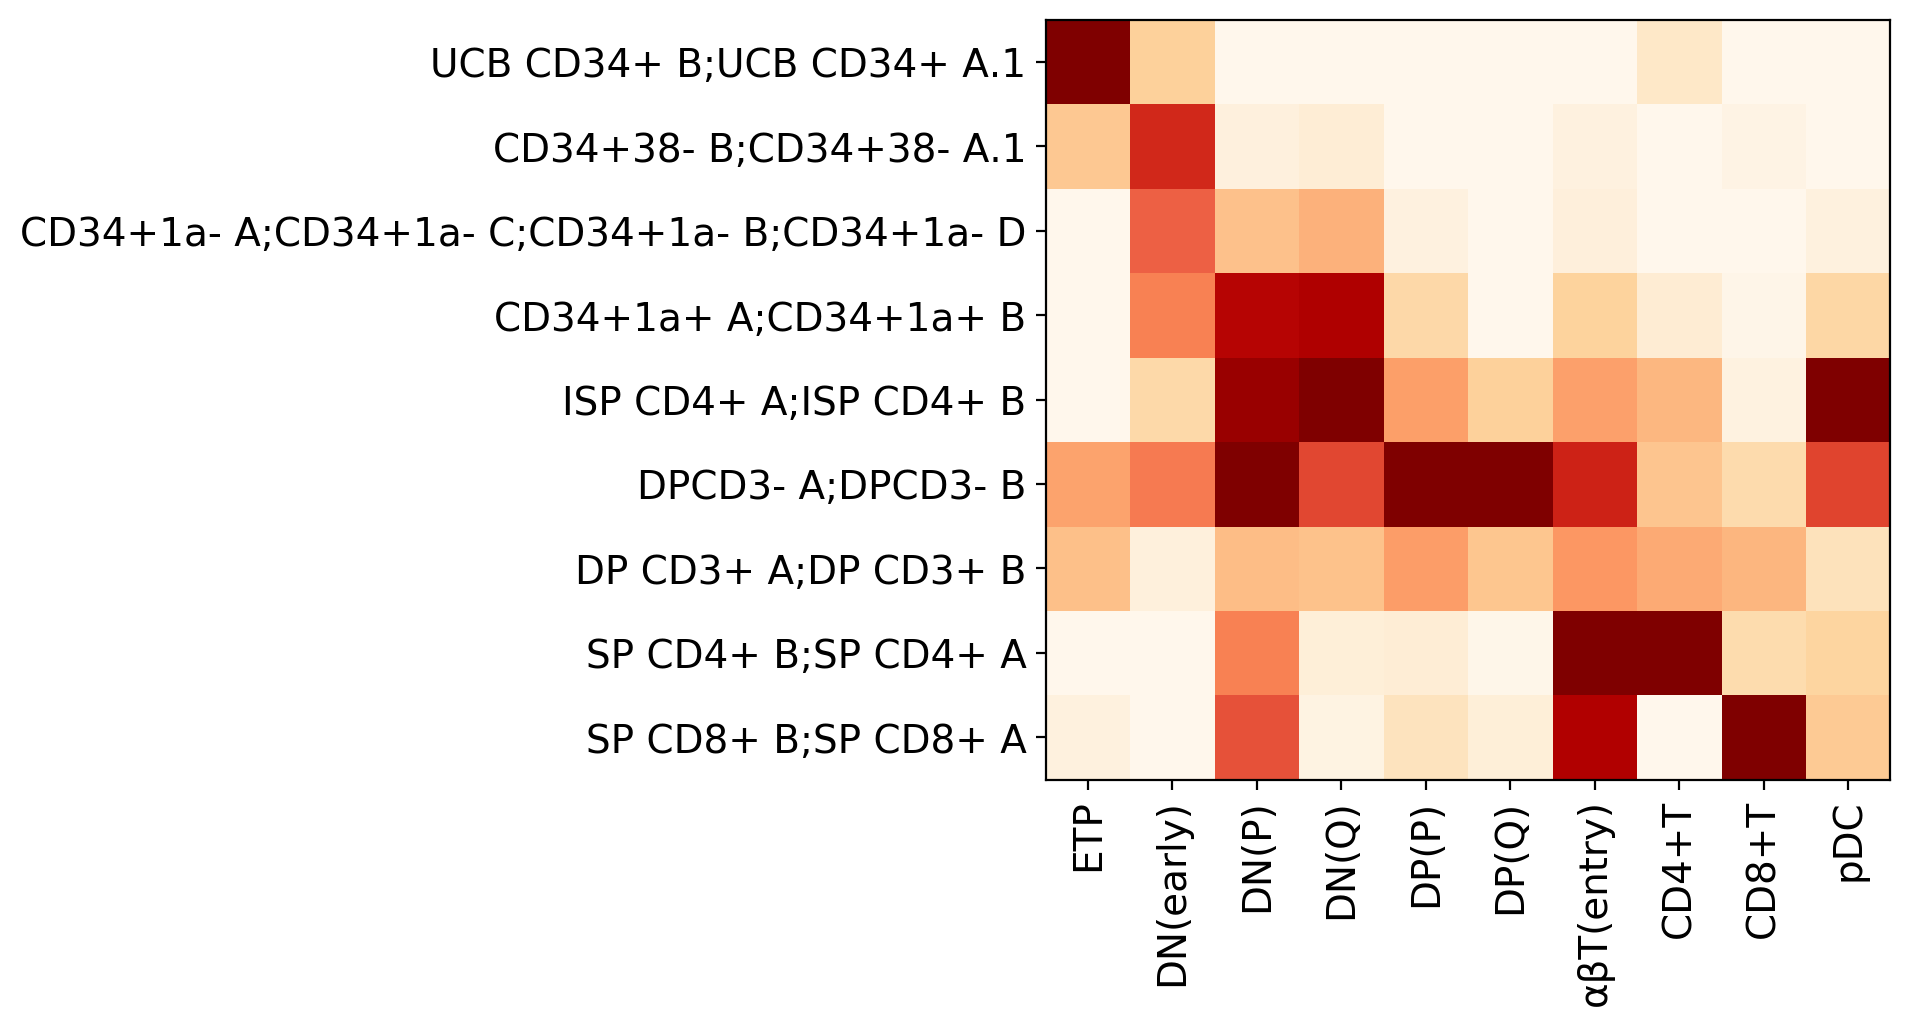

In [808]:
x_index = np.array([list(lr2.classes_).index(x) for x in x_order])

plt.figure(figsize=(10,5))
plt.imshow(scores_scaled[3:,x_index],vmin=0.2,cmap='OrRd')
xlabel = np.array(lr2.classes_)[x_index]
ylabel = list(sdata_common.obs_names)[3:]
plt.xticks(range(len(xlabel)),xlabel,rotation=90)
plt.yticks(range(len(ylabel)),ylabel)
plt.grid(False)
plt.show()

In [35]:
df_mean = pd.DataFrame(ndata_partial.uns['cdm_Anno_level_Staal']['mean'])

NameError: name 'ndata_partial' is not defined

In [991]:
df_mean.head()

B     CD4+T     CD8+T     CD8αα       DC1       DC2     DN(P)  \
0  0.026000  0.101574  0.117671  0.109294  0.109017  0.008874  0.089558   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.002242   
2  0.373757  0.495067  0.507177  0.489157  0.806326  0.828857  1.472394   
3  0.128262  0.187399  0.149693  0.155792  0.111912  0.112202  0.199036   
4  0.079436  0.107259  0.068833  0.065560  0.191348  0.140741  0.620763   

      DN(Q)  DN(early)     DP(P)     DP(Q)       ETP       NMP      Treg  \
0  0.085992   0.022918  0.130795  0.131292  0.024156  0.055520  0.041848   
1  0.000741   0.001302  0.000112  0.000188  0.000000  0.000000  0.000000   
2  0.814167   1.195187  1.161613  0.584221  0.810560  0.931603  0.445882   
3  0.137805   0.172120  0.195958  0.148688  0.142402  0.092723  0.162421   
4  0.084962   0.327054  0.686795  0.054807  0.184562  0.149053  0.150907   

        pDC  αβT(entry)       γδT  
0  0.006748    0.107535  0.204999  
1  0.000000    0.000337  0.000568  
2  0.731377    0.447706  1.272896  
3  0.215168    0.156353  0.194898  
4  0.045017    0.049290  0.342264

In [993]:
mdata = sc.AnnData(df_mean.T)
mdata.obs_names = df_mean.columns
mdata.var_names = ndata_partial.raw.var_names

Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [ ]:
sc.pp.scale(mdata,max_value=10)

## Load Staal et al (highly variable genes)

In [9]:
df = pd.read_csv('05_Staal/190707 Staal microarray.csv',header=1).iloc[:,2:-1]

In [10]:
df = df.set_index('Gene')

In [11]:
import seaborn as sns

In [12]:
import matplotlib.pyplot as plt

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()
df_norm = scaler.fit_transform(df.T).T

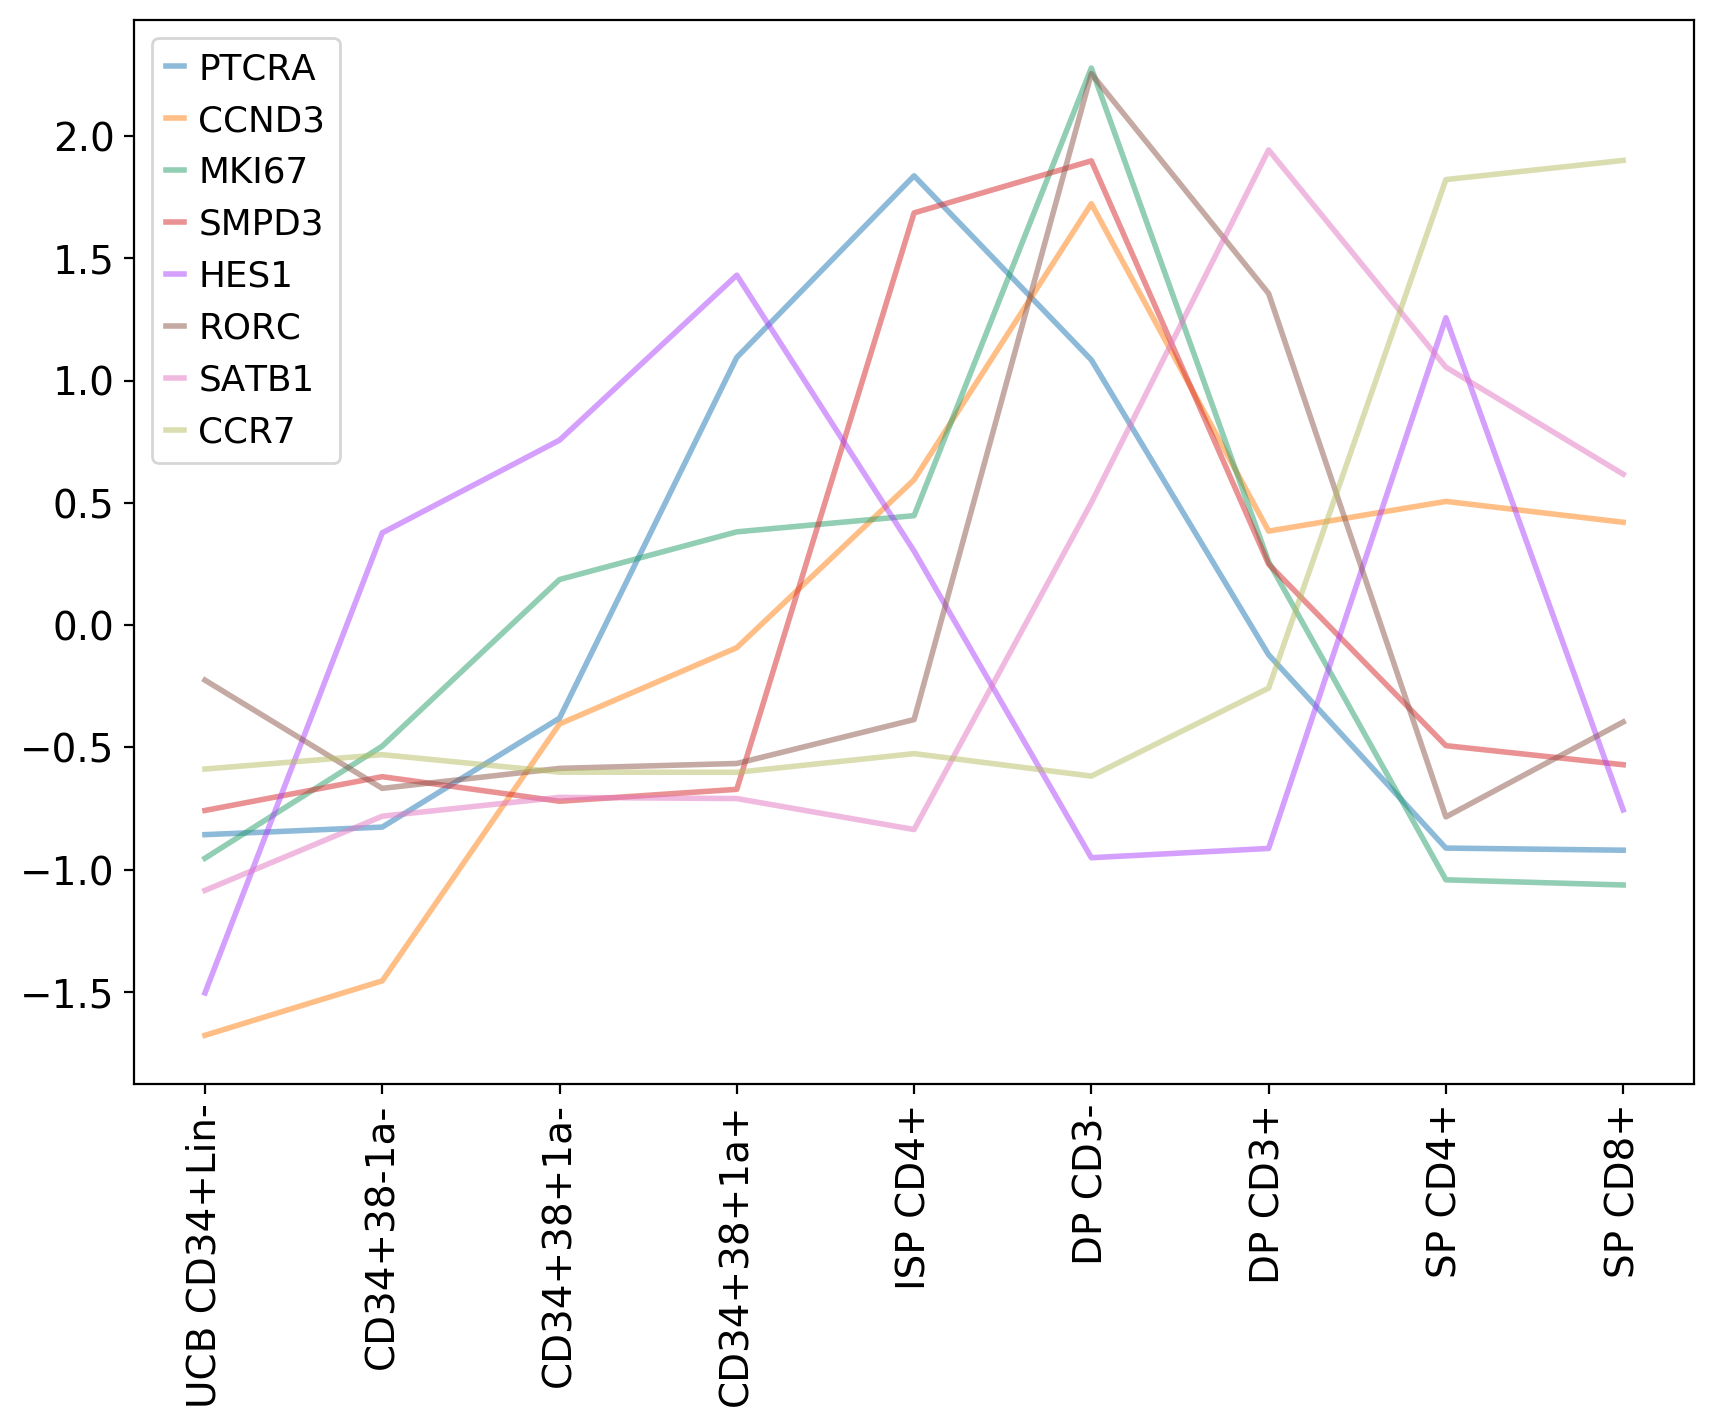

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,7))

for gene in ['PTCRA','CCND3','MKI67','SMPD3','HES1','RORC','SATB1','CCR7']:
    if sum(df.index==gene) > 0:
        #plt.plot(np.arange(len(df.columns)),np.array(df[df.index==gene])[0],label=gene,alpha=0.5,linewidth=2.0)
        plt.plot(np.arange(len(df.columns)),df_norm[df.index==gene][0],label=gene,alpha=0.5,linewidth=2.0)
plt.xticks(np.arange(len(df.columns)),list(df.columns),rotation=90)
plt.legend(loc='upper left')
plt.grid(False)
plt.show()

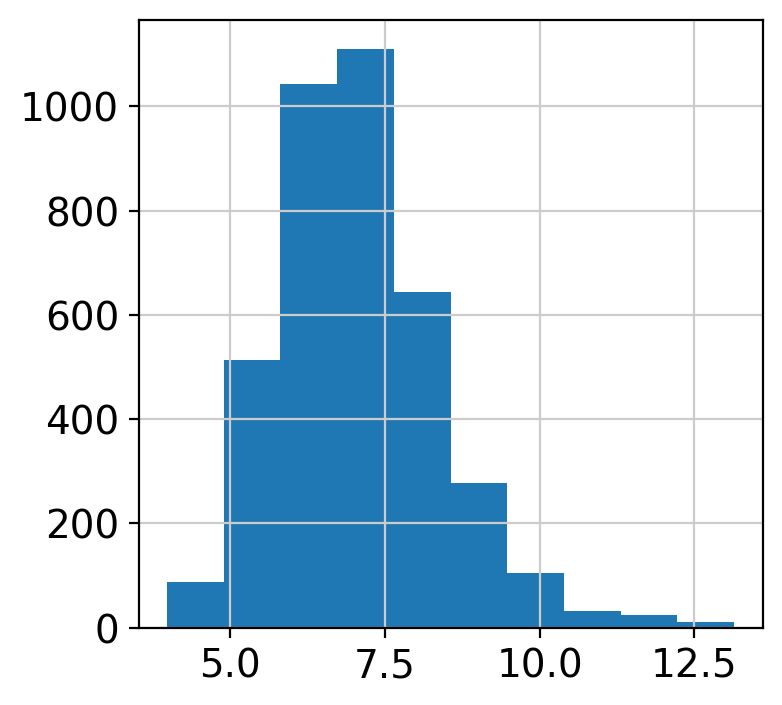

In [19]:
plt.hist(np.log2(np.mean(df,axis=1)))
plt.show()

In [20]:
df_log = np.log2(df)

## Annotation_structure

In [34]:
anno_meta = pd.read_csv('/mnt/thymus_atlas/Annotation_meta.tsv',sep='\t')

In [35]:
anno_meta.columns

Index(['Anno_level_1', 'Anno_level_2', 'Anno_level_3', 'Anno_level_4',
       'Anno_level_5', 'Anno_level_fig1', 'Anno_level_Staal'],
      dtype='object')

In [36]:
meta_to_update = anno_meta.columns

In [37]:
check_list = ndata.obs.columns.copy()
for cat in check_list:
    if cat in meta_to_update:
        print('deleting...:',cat)
        del ndata.obs[cat]
    else:
        pass

In [38]:
merged_obs = pd.merge(ndata.obs,anno_meta[meta_to_update],left_on='anno_predict_B',right_on='Anno_level_5',how='left')

In [39]:
merged_obs.index = ndata.obs_names

In [40]:
ndata.obs = merged_obs

In [49]:
ndata_partial = ndata[ndata.obs['Anno_level_Staal']!='T_memory'].copy()

In [50]:
mks = scjp.markers.find_markers(ndata_partial,'Anno_level_Staal',min_drop_cut=0.2)

/mnt/thymus_atlas/scjp/markers.py:166: RuntimeWarning:

invalid value encountered in true_divide



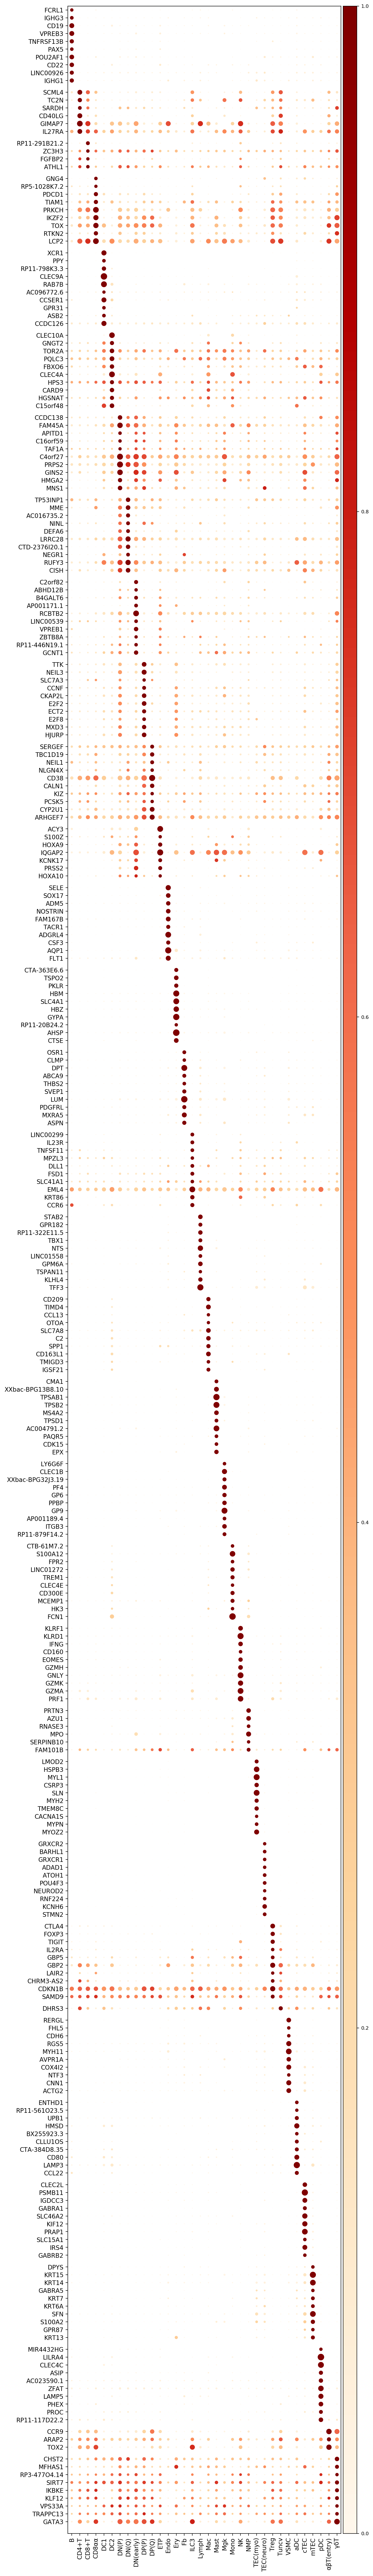

In [58]:
mk_genes = scjp.markers.show_marker_plot(ndata_partial,'Anno_level_Staal',mks)

In [62]:
variable_genes = [items for sublist in mk_genes.values() for items in sublist]

In [71]:
df_mean = pd.DataFrame(ndata_partial.uns['cdm_Anno_level_Staal']['mean'])

In [72]:
df_mean.head()

B     CD4+T     CD8+T     CD8αα       DC1       DC2     DN(P)  \
0  0.026000  0.101574  0.117671  0.109294  0.109017  0.008874  0.089558   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.002242   
2  0.373757  0.495067  0.507177  0.489157  0.806326  0.828857  1.472394   
3  0.128262  0.187399  0.149693  0.155792  0.111912  0.112202  0.199036   
4  0.079436  0.107259  0.068833  0.065560  0.191348  0.140741  0.620763   

      DN(Q)  DN(early)     DP(P)  ...  TEC(neuro)      Treg     Tuncv  \
0  0.085992   0.022918  0.130795  ...    0.415875  0.041848  0.114560   
1  0.000741   0.001302  0.000112  ...    0.000000  0.000000  0.000000   
2  0.814167   1.195187  1.161613  ...    0.565466  0.445882  0.598723   
3  0.137805   0.172120  0.195958  ...    0.154814  0.162421  0.172653   
4  0.084962   0.327054  0.686795  ...    0.263765  0.150907  0.113927   

       VSMC       aDC      cTEC      mTEC       pDC  αβT(entry)       γδT  
0  0.255750  0.035520  1.118971  0.844208  0.006748    0.107535  0.204999  
1  0.267099  0.000000  0.050911  0.007412  0.000000    0.000337  0.000568  
2  0.395052  0.539888  1.173589  0.523897  0.731377    0.447706  1.272896  
3  0.062955  0.108704  0.127568  0.129175  0.215168    0.156353  0.194898  
4  0.039671  0.038649  0.134481  0.095915  0.045017    0.049290  0.342264  

[5 rows x 34 columns]

In [78]:
mdata = sc.AnnData(df_mean.T)
mdata.obs_names = df_mean.columns
mdata.var_names = ndata_partial.raw.var_names

Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [56]:
df_log.head()

UCB CD34+Lin-  CD34+38-1a-  CD34+38+1a-  CD34+38+1a+   ISP CD4+  \
Gene                                                                    
GZMB       5.698218     5.526069     5.923862     5.902797  10.375811   
IRF7       6.876517     7.083958     7.338959     6.267536  10.417399   
ILT7       5.708463     5.744161     6.051372     5.887038   9.382148   
BLNK       3.455492     5.416164     6.155628     4.835924   8.316236   
UGCG       4.883132     5.741737     6.602736     6.313790   9.756239   

       DP CD3-   DP CD3+   SP CD4+   SP CD8+  
Gene                                          
GZMB  5.810700  5.983450  5.509062  6.195938  
IRF7  6.134632  6.898692  9.146110  8.942016  
ILT7  6.228819  6.730368  5.976593  5.871351  
BLNK  4.440952  4.790251  4.418190  4.365972  
UGCG  7.075533  7.414728  8.821774  8.814166

In [90]:
mdata.raw = mdata
sdata.raw = sdata

In [82]:
mdata, sdata = scjp.model.get_common_var_raw(mdata,sdata)

calculating a...
calculating b...


In [115]:
ndata_common, sdata_common = scjp.model.get_common_var_raw(ndata_partial,sdata)

calculating a...
calculating b...


creating lr model...


/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



making lr prediction...
updating lr to adata...


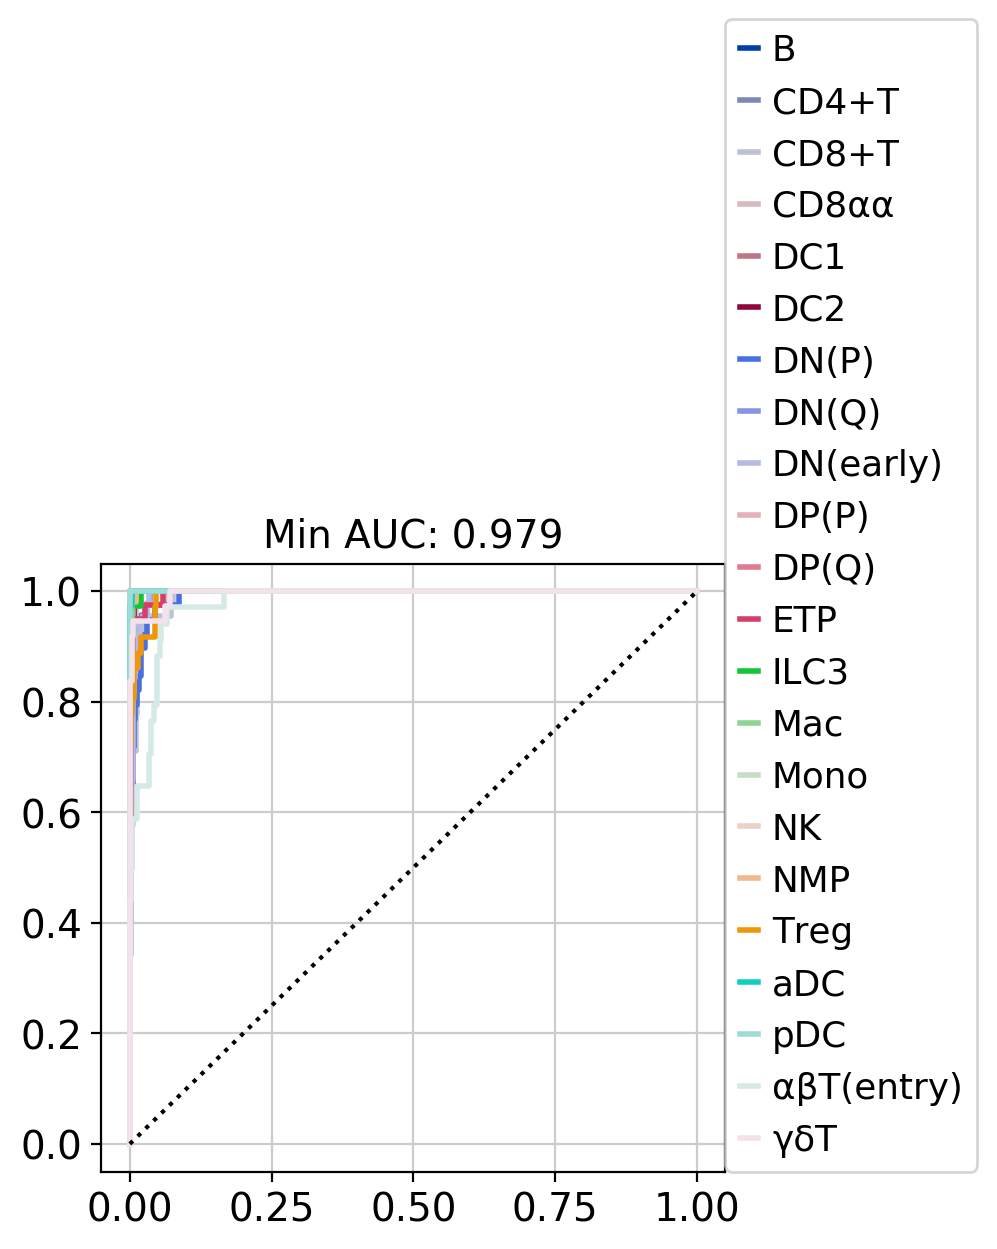

In [116]:
lr = scjp.model.transfer_annotation_jp(ndata_common,'Anno_level_Staal',sdata_common,'prediction',raw=False)

In [117]:
proba = lr.predict_proba(sdata_common.X)

In [118]:
sdata_common.obs['prediction']

UCB CD34+Lin-          DC2
CD34+38-1a-      DN(early)
CD34+38+1a-      DN(early)
CD34+38+1a+            γδT
ISP CD4+               γδT
DP CD3-                γδT
DP CD3+                γδT
SP CD4+                γδT
SP CD8+                γδT
Name: prediction, dtype: object

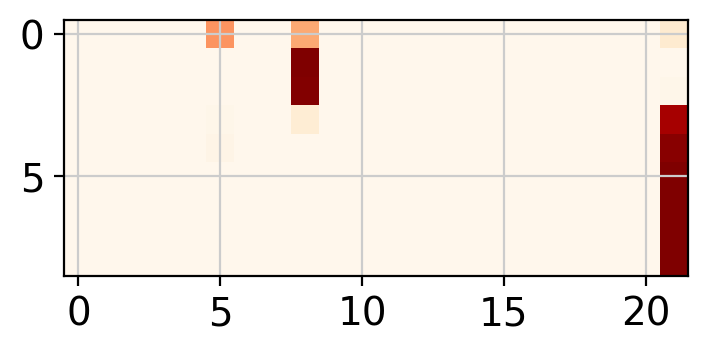

In [119]:
plt.imshow(proba)


## Negative binomial part

In [ ]:
df = level3['raw_count'].T
df.columns = list(df.columns)
df['stage'] = [x.split('_')[-1] for x in df.index]
df['stage2'] = [cvt_stage(x) for x in df['stage']]

In [ ]:
endog = df['Mac']

In [ ]:
exog = pd.get_dummies(df['stage2'])

In [ ]:
exposure = df['DC1']+df['DC2']+df['pDC']+df['Mac']+df['Mono']

In [ ]:
import statsmodels as sm
nb = sm.discrete.discrete_model.NegativeBinomial(endog,exog,exposure=np.array(exposure))

In [ ]:
nb_res = nb.fit()

In [ ]:
nb_res.summary()

In [ ]:
cell_list = "ILC3,NK,γδT,CD4+T,CD8+T,CD8+Tmem,CD4+Tmem,B_naive,B_memory".split(",")
df_dict['Lymphocyte'] = utils.get_df_for_cell_population_v2(cell_list,level4,style='raw',size=10)

In [ ]:
cell_list = "CD4+CTL,CD4+PD1,CD4+T,CD4+Tmem,CD8+T,CD8+Tmem,Tfh,Th17,Treg(diff),Treg,CD8αα(I),CD8αα(II)".split(",")
df_dict['Lymphocyte'] = utils.get_df_for_cell_population_v2(cell_list,level5,style='raw',size=10)

## Run separate analysis per donor

In [ ]:
ad = {}

In [ ]:
set(ndata[~ndata.obs['is_file_Fig1']].obs['donor'])

In [ ]:
for donor in set(ndata.obs['donor']):
    ad[donor] = scjp.get_subset(ndata,ndata.obs['donor']==donor)
    sc.pp.neighbors(ad[donor])
    sc.tl.umap(ad[donor])
    sc.tl.leiden(ad[donor])

In [ ]:
for donor in ad:
    ad[donor].obsm['X_umap_indiv'] = ad[donor].obsm['X_umap']
    ad[donor].obsm['X_umap_combi'] = ndata.obsm['X_umap'][ndata.obs['donor']==donor]

In [ ]:
for donor in ad:
    ad[donor].obs['anno_pred'] = ndata.obs['anno_pred'][ndata.obs['donor']==donor]
    ad[donor].obsm['X_umap'] = ad[donor].obsm['X_umap_combi']

## Comparison between donors

In [ ]:
anno_pred_cats = sorted(set(ndata.obs['anno_pred']))
anno_pred_colors = ndata.uns['anno_pred_colors']
anno_pred_dict = {cat:color for cat,color in zip(anno_pred_cats,anno_pred_colors)}

In [ ]:
def show_umap_anno_pred(donor,to_show_list):
    sdata = ndata[ndata.obs['donor']==donor]
    sdata.uns['anno_pred_colors'] =  [anno_pred_dict[cat] for cat in sorted(set(sdata.obs['anno_pred']))]
    scjp.us(sdata,to_show_list)
    plt.show()

In [ ]:
to_show_list = ['anno_pred']

In [ ]:
donor_list = ['C40','C41','F22','C34','F64','F23']+['F67','F45','F38','F30','F21','F41','F29','F83']+['P3','T07','T03','P1','T06','P2']+['A45','A16','A43']

In [ ]:
scjp.us(ndata,'anno_pred')

In [ ]:
for donor in ['F1','F2','F3','F4','P1','P2','A1']:
    c_noF32 = ndata.obs['donor']!='F32'
    print(donor)
    xmin = np.min(ndata.obsm['X_umap'][:,0])
    xmax = np.max(ndata.obsm['X_umap'][:,0])
    ymin = np.min(ndata.obsm['X_umap'][:,1])
    ymax = np.max(ndata.obsm['X_umap'][:,1])
    c_donor = (ndata.obs['Stage']==donor) & (c_noF32)
    xy = ndata.obsm['X_umap'][c_donor]
    anno = np.array(ndata.obs['anno_pred'][c_donor])
    x1 = xy[:,0]
    y1 = xy[:,1]
    for cat,color in zip(anno_pred_cats,anno_pred_colors):
        c_anno = anno==cat
        plt.scatter(x1[c_anno],y1[c_anno],color=color,s=1)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.grid(False)
    plt.show()

In [ ]:
for donor in ['C40','C41','F22','C34','F64','F23']:
    show_umap_anno_pred(donor,to_show_list)

In [ ]:
for donor in ['F67','F45','F38','F30','F21','F41','F29','F83']:
    show_umap_anno_pred(donor,to_show_list)

In [ ]:
for donor in ['P3','T07','T03','P1','T06','P2']:
    show_umap_anno_pred(donor,to_show_list)

In [ ]:
for donor in ['A45','A16','A43']:
    show_umap_anno_pred(donor,to_show_list)

## [appendix] look into metadata

In [ ]:
fetus_age_list = [("F32",'7w'), ('F35','7w.2'), 
             ('F34','8w'), ("F22",'9w'), 
             ('F33','9w.2'), ('F64','11w'), 
             ("F23",'11w.2'), ('F67','12w'),
             ("F45",'12w'), ("F38", '13w'), 
             ("F30",'14w'), ('F50','15w'),
             ('F51','15w.2'), ('F21','16w'),
             ("F41",'16w.2'), ("F29",'17w'),
             ("P3",'0-1y'), ('P1','1-2y'),
             ("P2",'10-15y'),  ("A16",'20-25y')]

fetus_gender = {"F21":"Male", "F22":"Female", "F23":"Male",
                "F29":"Female", "F30":"Male", "F32":"Female",
                "F38": "Male", "F41":"Female", "F45":"Female",
                "A16":"Female",'P1':'Male','P2':'Male',
                'P3':'Male','F35':'Female','F34':'Female',
                'F33':'Female','F50':'Female','F51':'Female'}

for fetus in fetus_age_list:
    fetID = fetus[0]
    AgeID = fetus[1]
    try: Gender = fetus_gender[fetID]
    except: Gender = 'unknown'
    
    print('\t'.join([fetID,AgeID,Gender]))

In [ ]:
for donor in set(ndata.obs['donor']):
    sdata = ndata[ndata.obs['donor']==donor]
    Xgenes = np.mean(sdata.raw.X[:,ndata.raw.var_names=='XIST'],axis=0)
    Ygenes = np.mean(sdata.raw.X[:,ndata.raw.var_names=='RPS4Y1'],axis=0)
    print(donor,Xgenes,Ygenes)